# An introduction to SAMBA: Trivariate Bayesian Model Mixing w/GPs

## Alexandra Semposki

### Date: 07 June 2022

From the last notebook, you saw the bivariate model mixing produce a well-mixed model with an overly conservative uncertainty band in the gap (for our toy model). We now want to try mixing in an interpolant in the form of a Gaussian Process (GP). This will enter $f^{\dagger}$ as a third individual model. Recall the function for $f^\dagger$:

$$
f^{\dagger} \sim \bigl(Z_P^{-1}\sum_k \frac{1}{v_k}f_k, Z_P^{-1}\bigr),
$$

where 

$$
Z_P \equiv \sum_{k=1}^{K}\frac{1}{v_k}.
$$

$Z_P$ is the precision, or the inverse of the variance, of the $K$ models, $v_{k}$ the individual variances of each model (which we previously denoted the theory error), and $f^{\dagger}$ the mixed model. Now $K = 3$ for this trivariate case.

We start by loading all of our necessary packages and SAMBA classes.

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

#matplotlib settings for Latex plots
import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})

In [2]:
#import the SAMBA classes needed
from models import Models, Uncertainties
from discrepancy import Bivariate
from gaussprocess import GP
from fprdat import FPR

As usual, we start by defining two series expansions to mix. We will begin with $N_{s} = N_{l} = 3$. (Note that we could mix more than two series expansions, but we're sticking with the bare minimum in this tutorial.)

In [3]:
#define g and series expansions
g = np.linspace(1e-6,1.0,200)
ns = 3
nl = 3

Now we instantiate the GP class, which acts as a wrapper for the Python package scikit learn. We immediately pick the kernel we wish to use for the GP here. The options are RBF, Matern, and Rational Quadratic. If we want to pick Matern, we also supply the value of $\nu$ when asked. This is shown below.

In [4]:
#instantiate GP object for N_s = N_l = 3
obj1 = GP(g, ns, nl, kernel="Matern", ci=68)

Which error model do you want to use, uninformative or informative? (u/i)i
Using the informative error model.
Enter a value for nu (standard: 0.5, 1.5, 2.5).1.5
Initializing standard Constant * Matern kernel.


Now we have a GP object that will use the Matern 3/2 kernel for its analysis. When using a GP, we need to train on a set of data. In a typical situation where the user has data to give the GP, these would be the training points used. However, in our case, with a toy model, we must generate these training points. In SAMBA, the training points are chosen by offsetting the original linspace in $g$ by a small amount, so a completely new linspace in $g$ is created that does not overlap exactly with any of the points first given to the GP class. This is because those points will be used in both the series expansion calculation and the GP prediction---which means, if we want the series expansions and GP to mix correctly in $f^\dagger$, we need to have the points in $g$ for all three models to be the same, or we will not be mixing the right points. Hence, we create a training set __after__ a prediction set for the toy model, unlike in real situations. 

SAMBA takes care of generating this new training array for you, but it does request that you choose a method to determine the fourth and final training point, located within the region of the large-$g$ expansion. This is because there are many different ways we could assign that training point. The three methods that we tried are 

- Fixing the point at $g = 0.6$ (independent of the location of the gap)

- Choosing the point in the array computed for the large-$g$ expansion where the value of $F_s(g)$ cuts off (where we choose to cut off the calculation of the small-$g$ expansion at the edge of the pertinent domain in $F(g)$)

- Putting the training point at the location where the theory error on the current point in the large-$g$ expansion array is larger than 5% of the next value of $F_l(g)$ in the array

SAMBA places the other 3 points at fixed points: two in the small-$g$ expansion array, and one at $g = 1$ in the large-$g$ expansion. 

In our tutorial, we pick __method 2__, which tends to yield the best results when comparing the true curve to the mixed model. However, none of the 3 methods are spectacularly better than the others, which shows how the GP is not overly dependent on the placement of the training points (great news for generalizing this!). We also select 'error=True' in the arguments of the training() function, because we wish to use the theory errors in our GP. 

Current training method: 2
Gaussian process parameters: 2.27**2 * Matern(length_scale=2.08, nu=1.5)


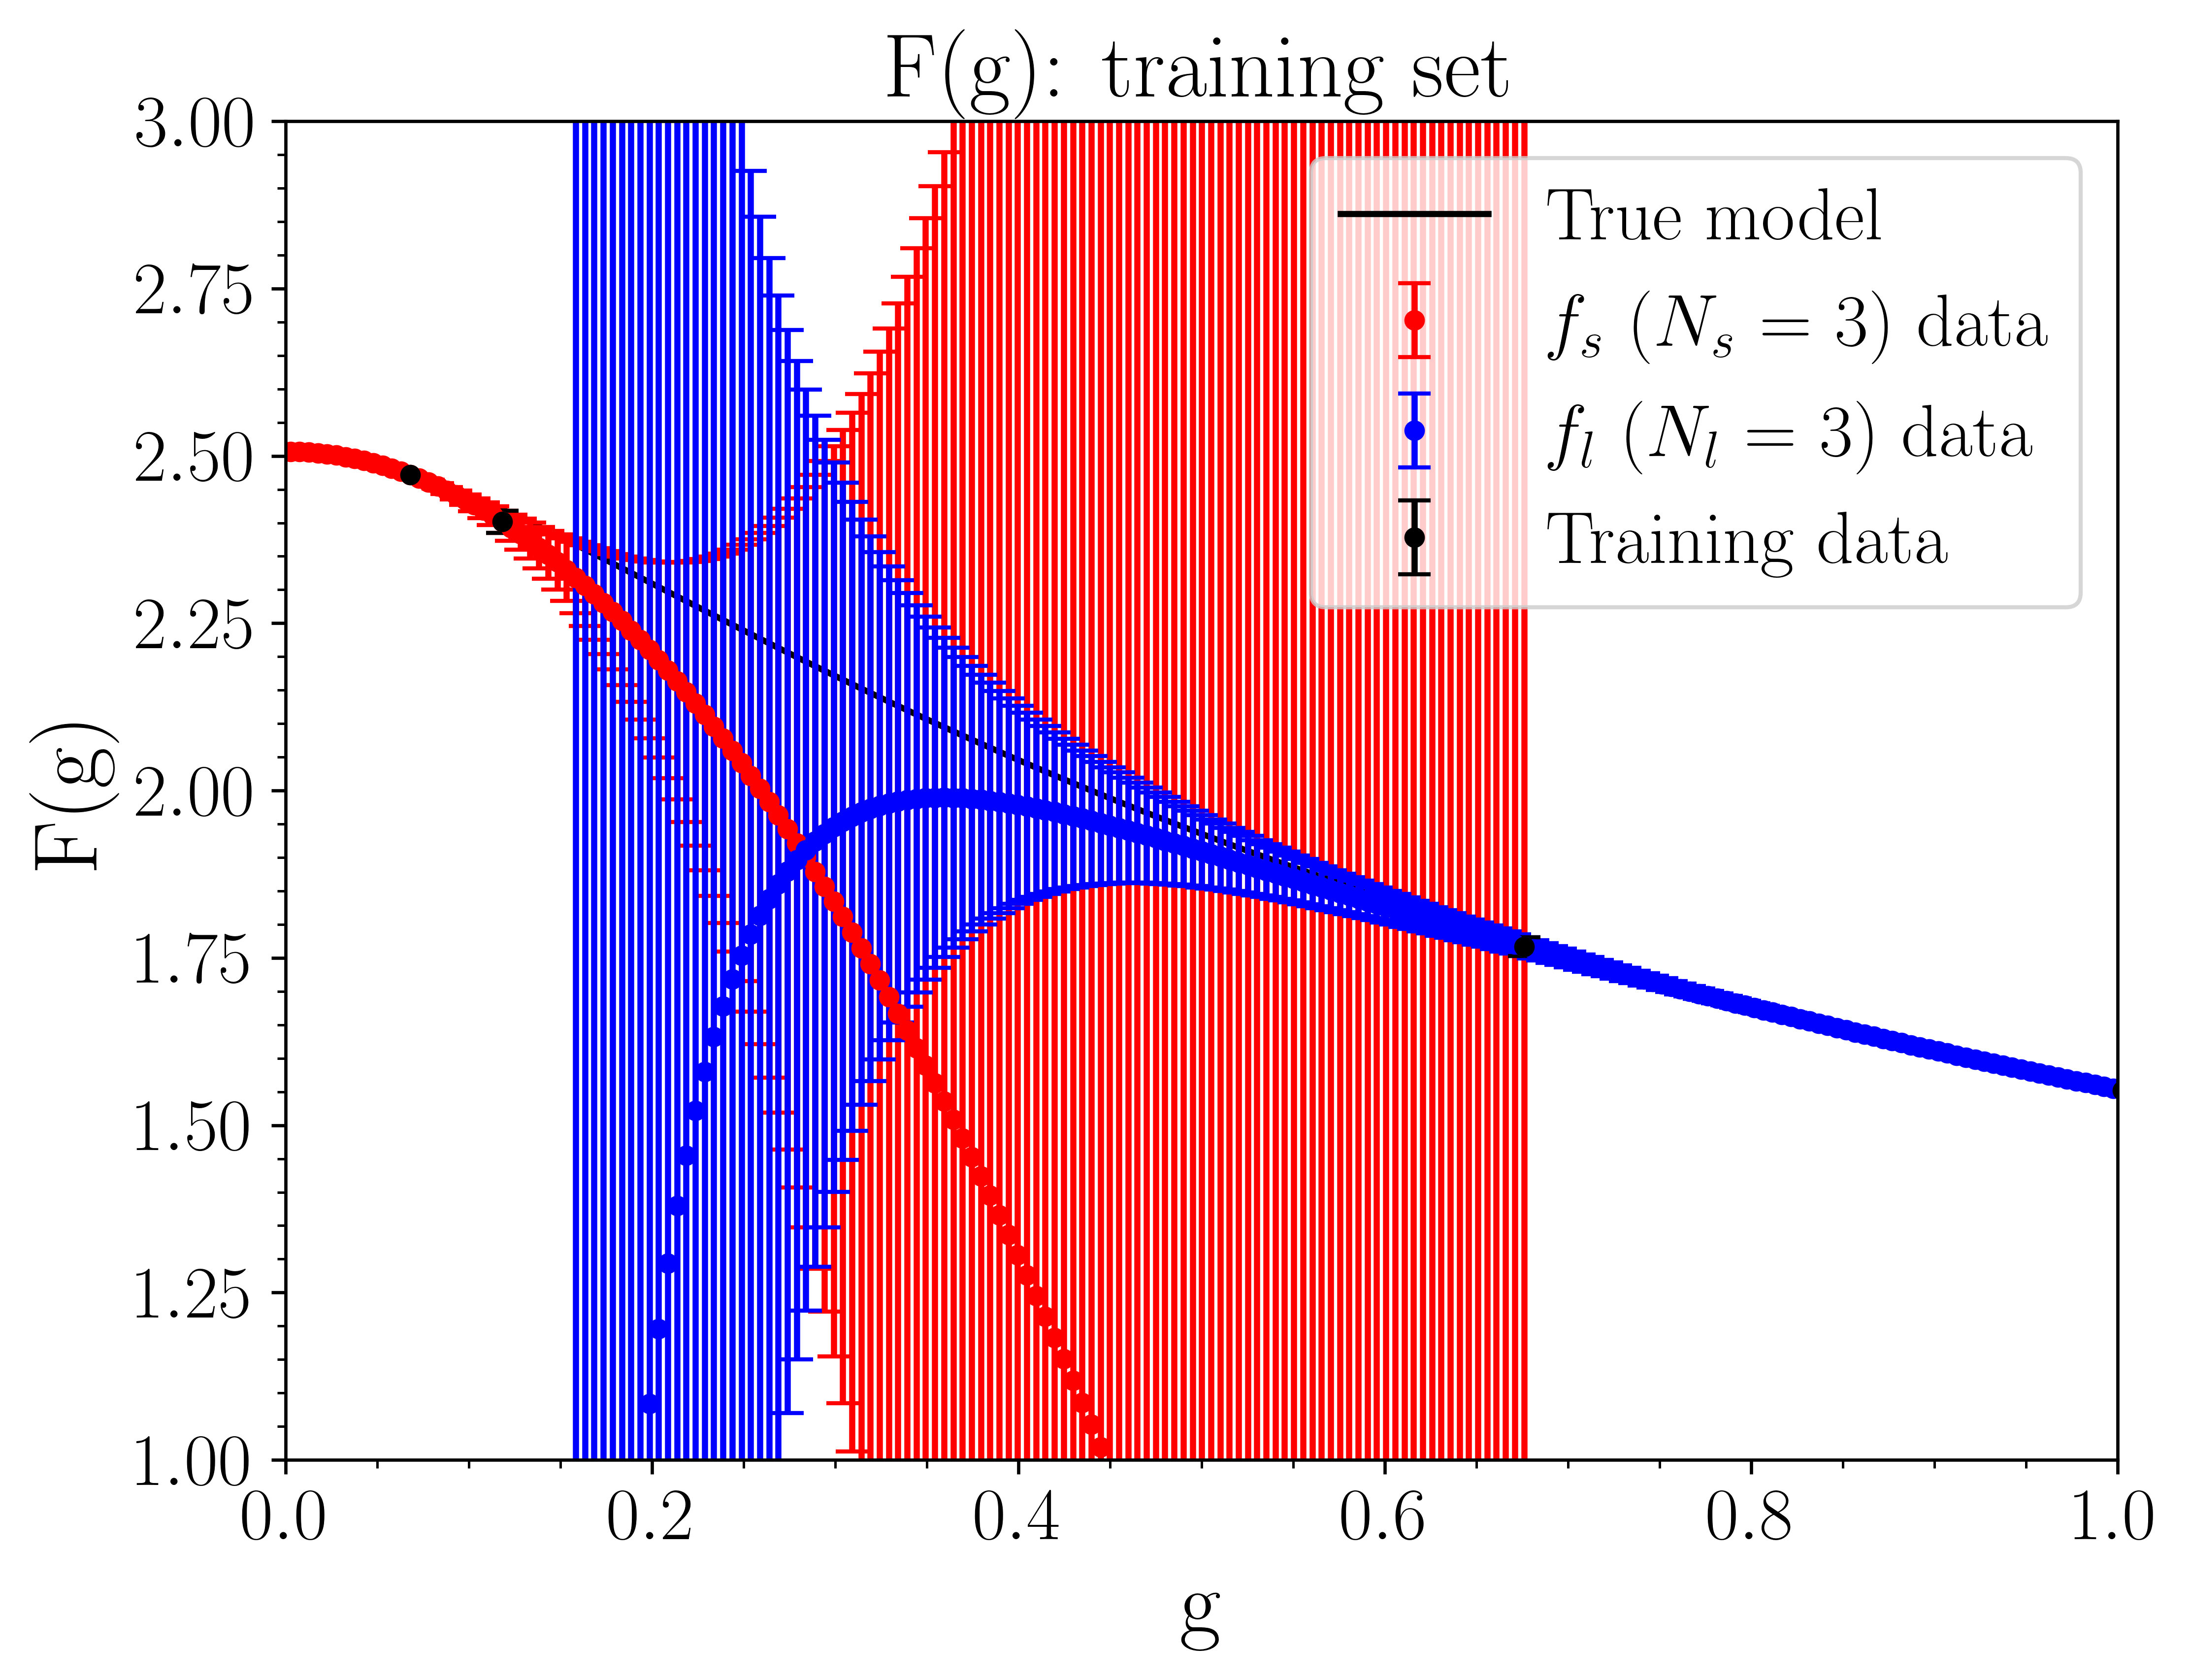

In [5]:
#call the training() function from the GP() class
obj_tr1 = obj1.training(error=True, method=2)

The plot above shows the theory errors on each calculated training point, with the red and blue curves being the small-$g$ and large-$g$ expansions, as usual. The black points are the four chosen training points for our GP that it just used to train itself. We will now use the validate() function in the GP class to predict at each original point in $g$. 

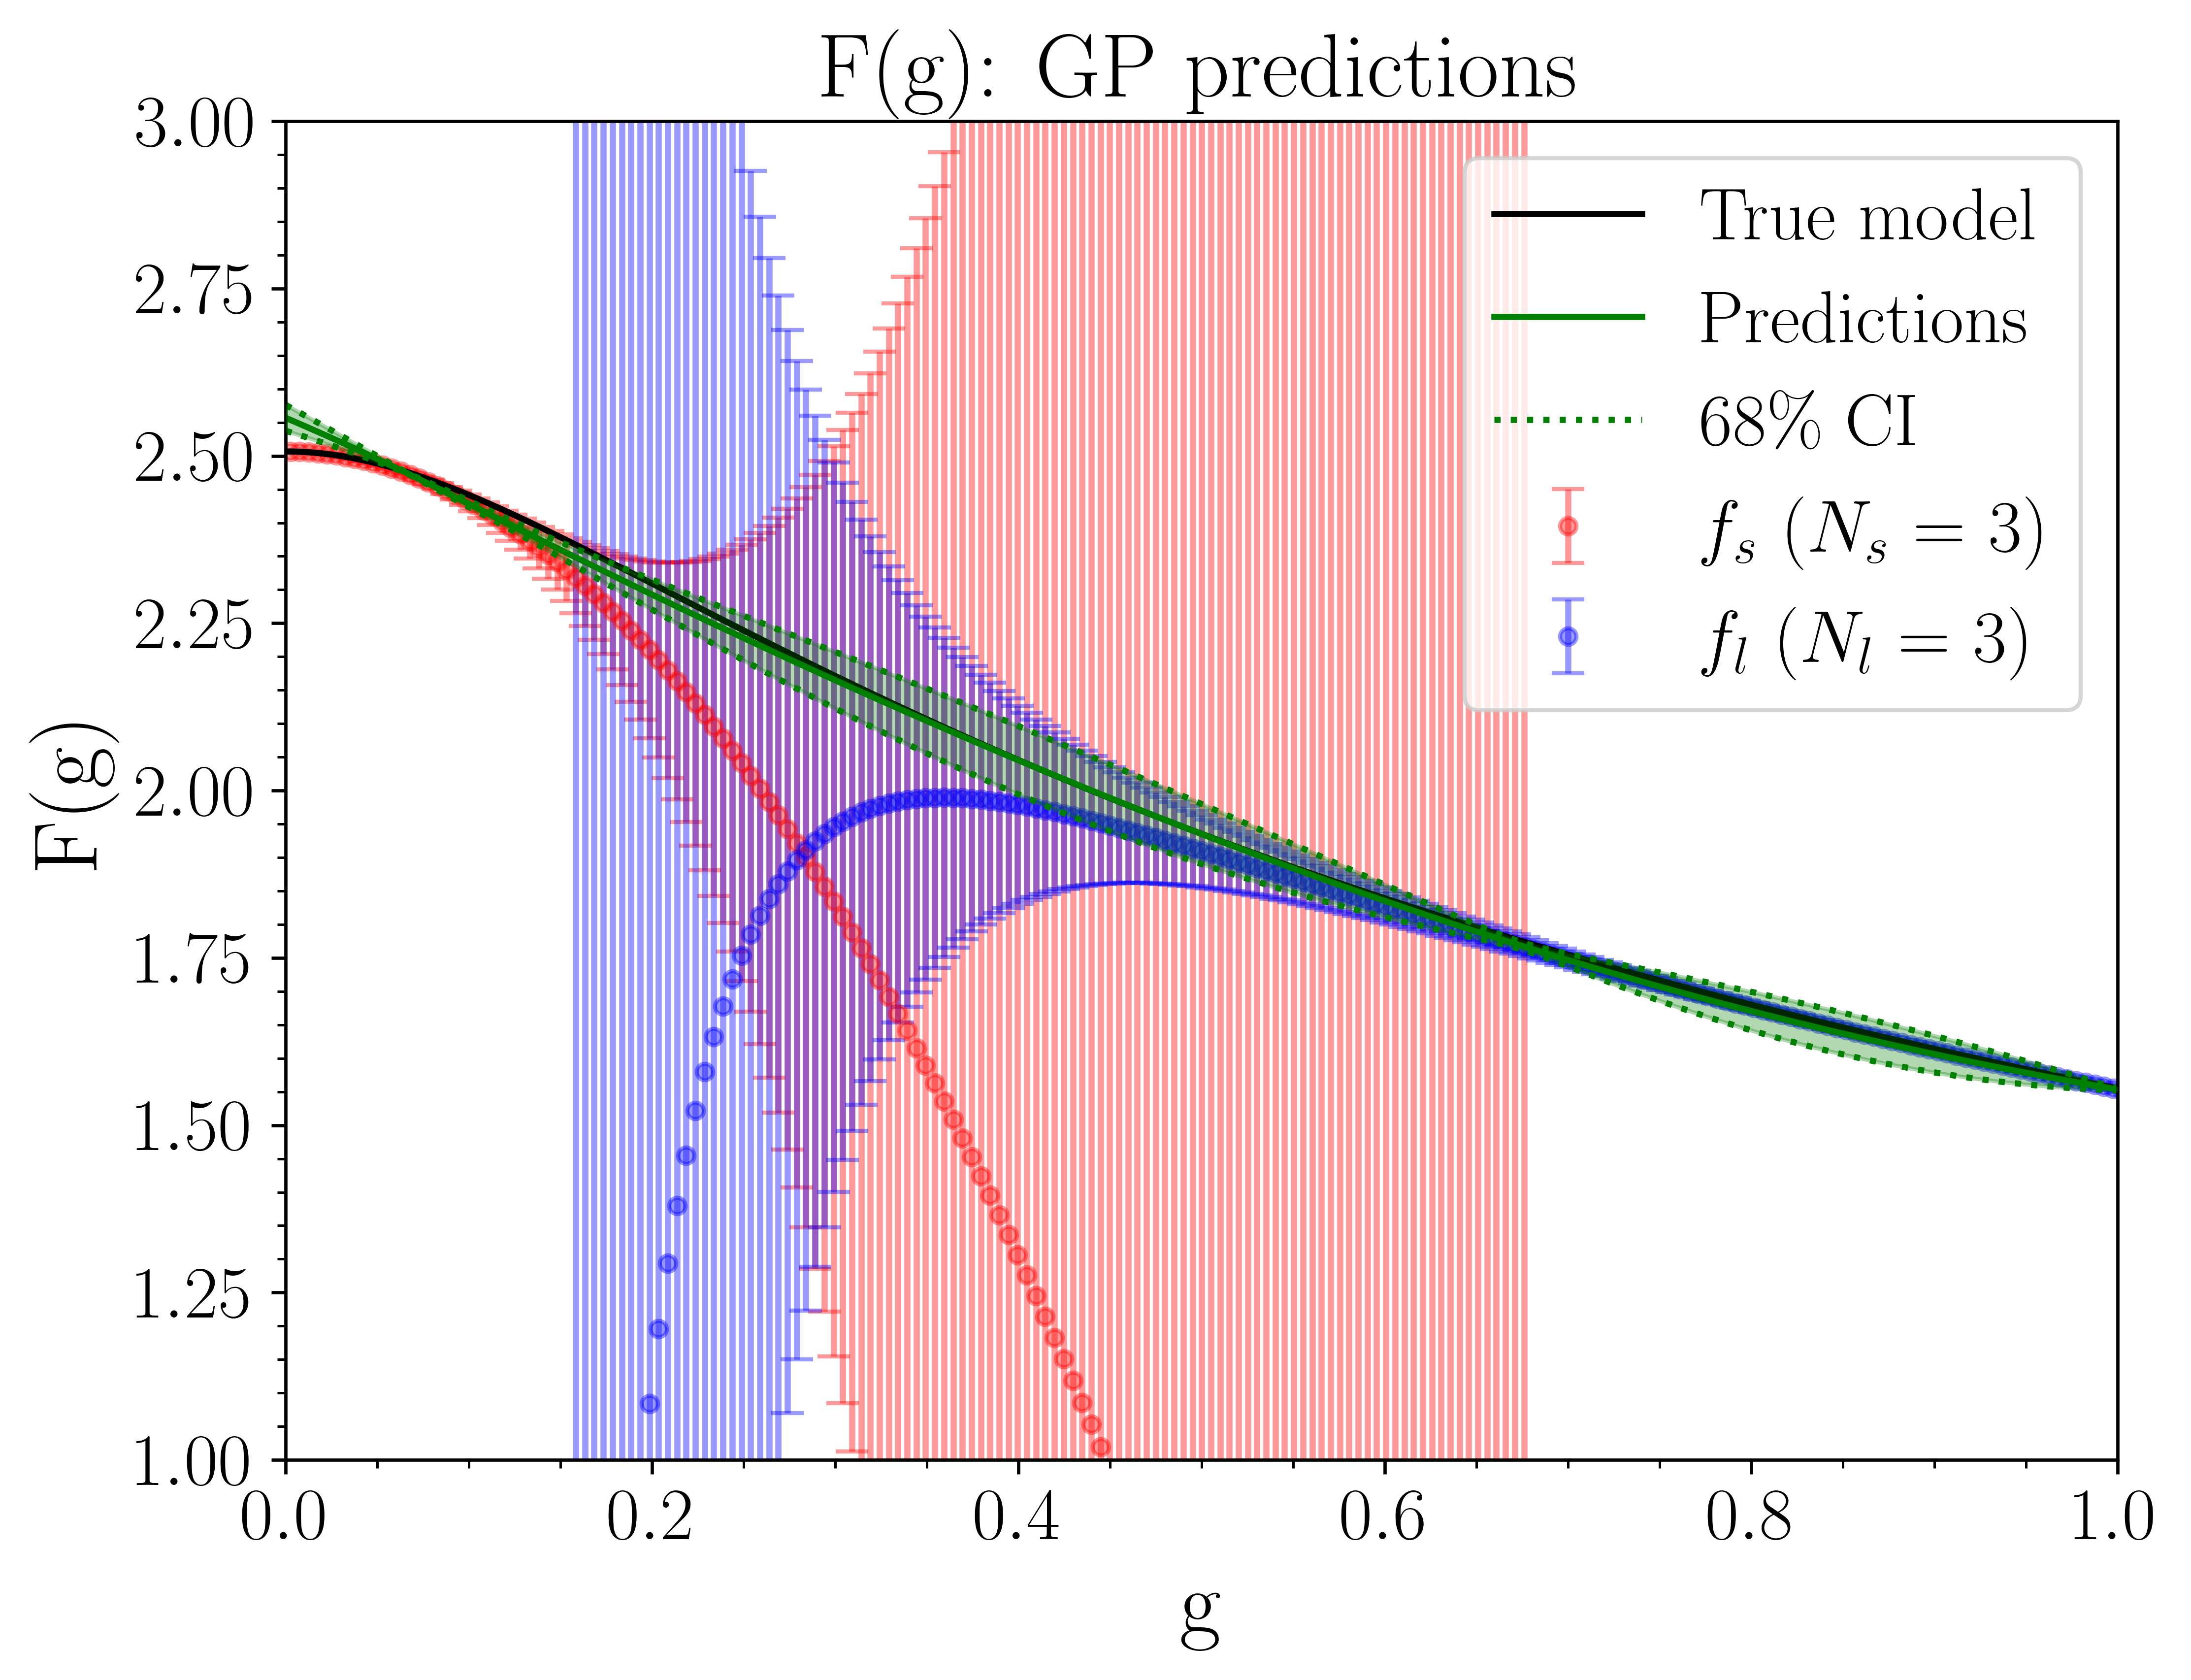

In [6]:
#call the validate() function
mean1, sig1, cov1 = obj1.validate()

We can now see the shaded green region and green curve in the plot above, which correspond to the GP variance band and GP mean curve, respectively. 

Now comes the time to mix this model in with the two expansions and see what we get. To do this, we call __plot_mix()__ from the Bivariate() class again, but this time we send it the GP mean and variance results.

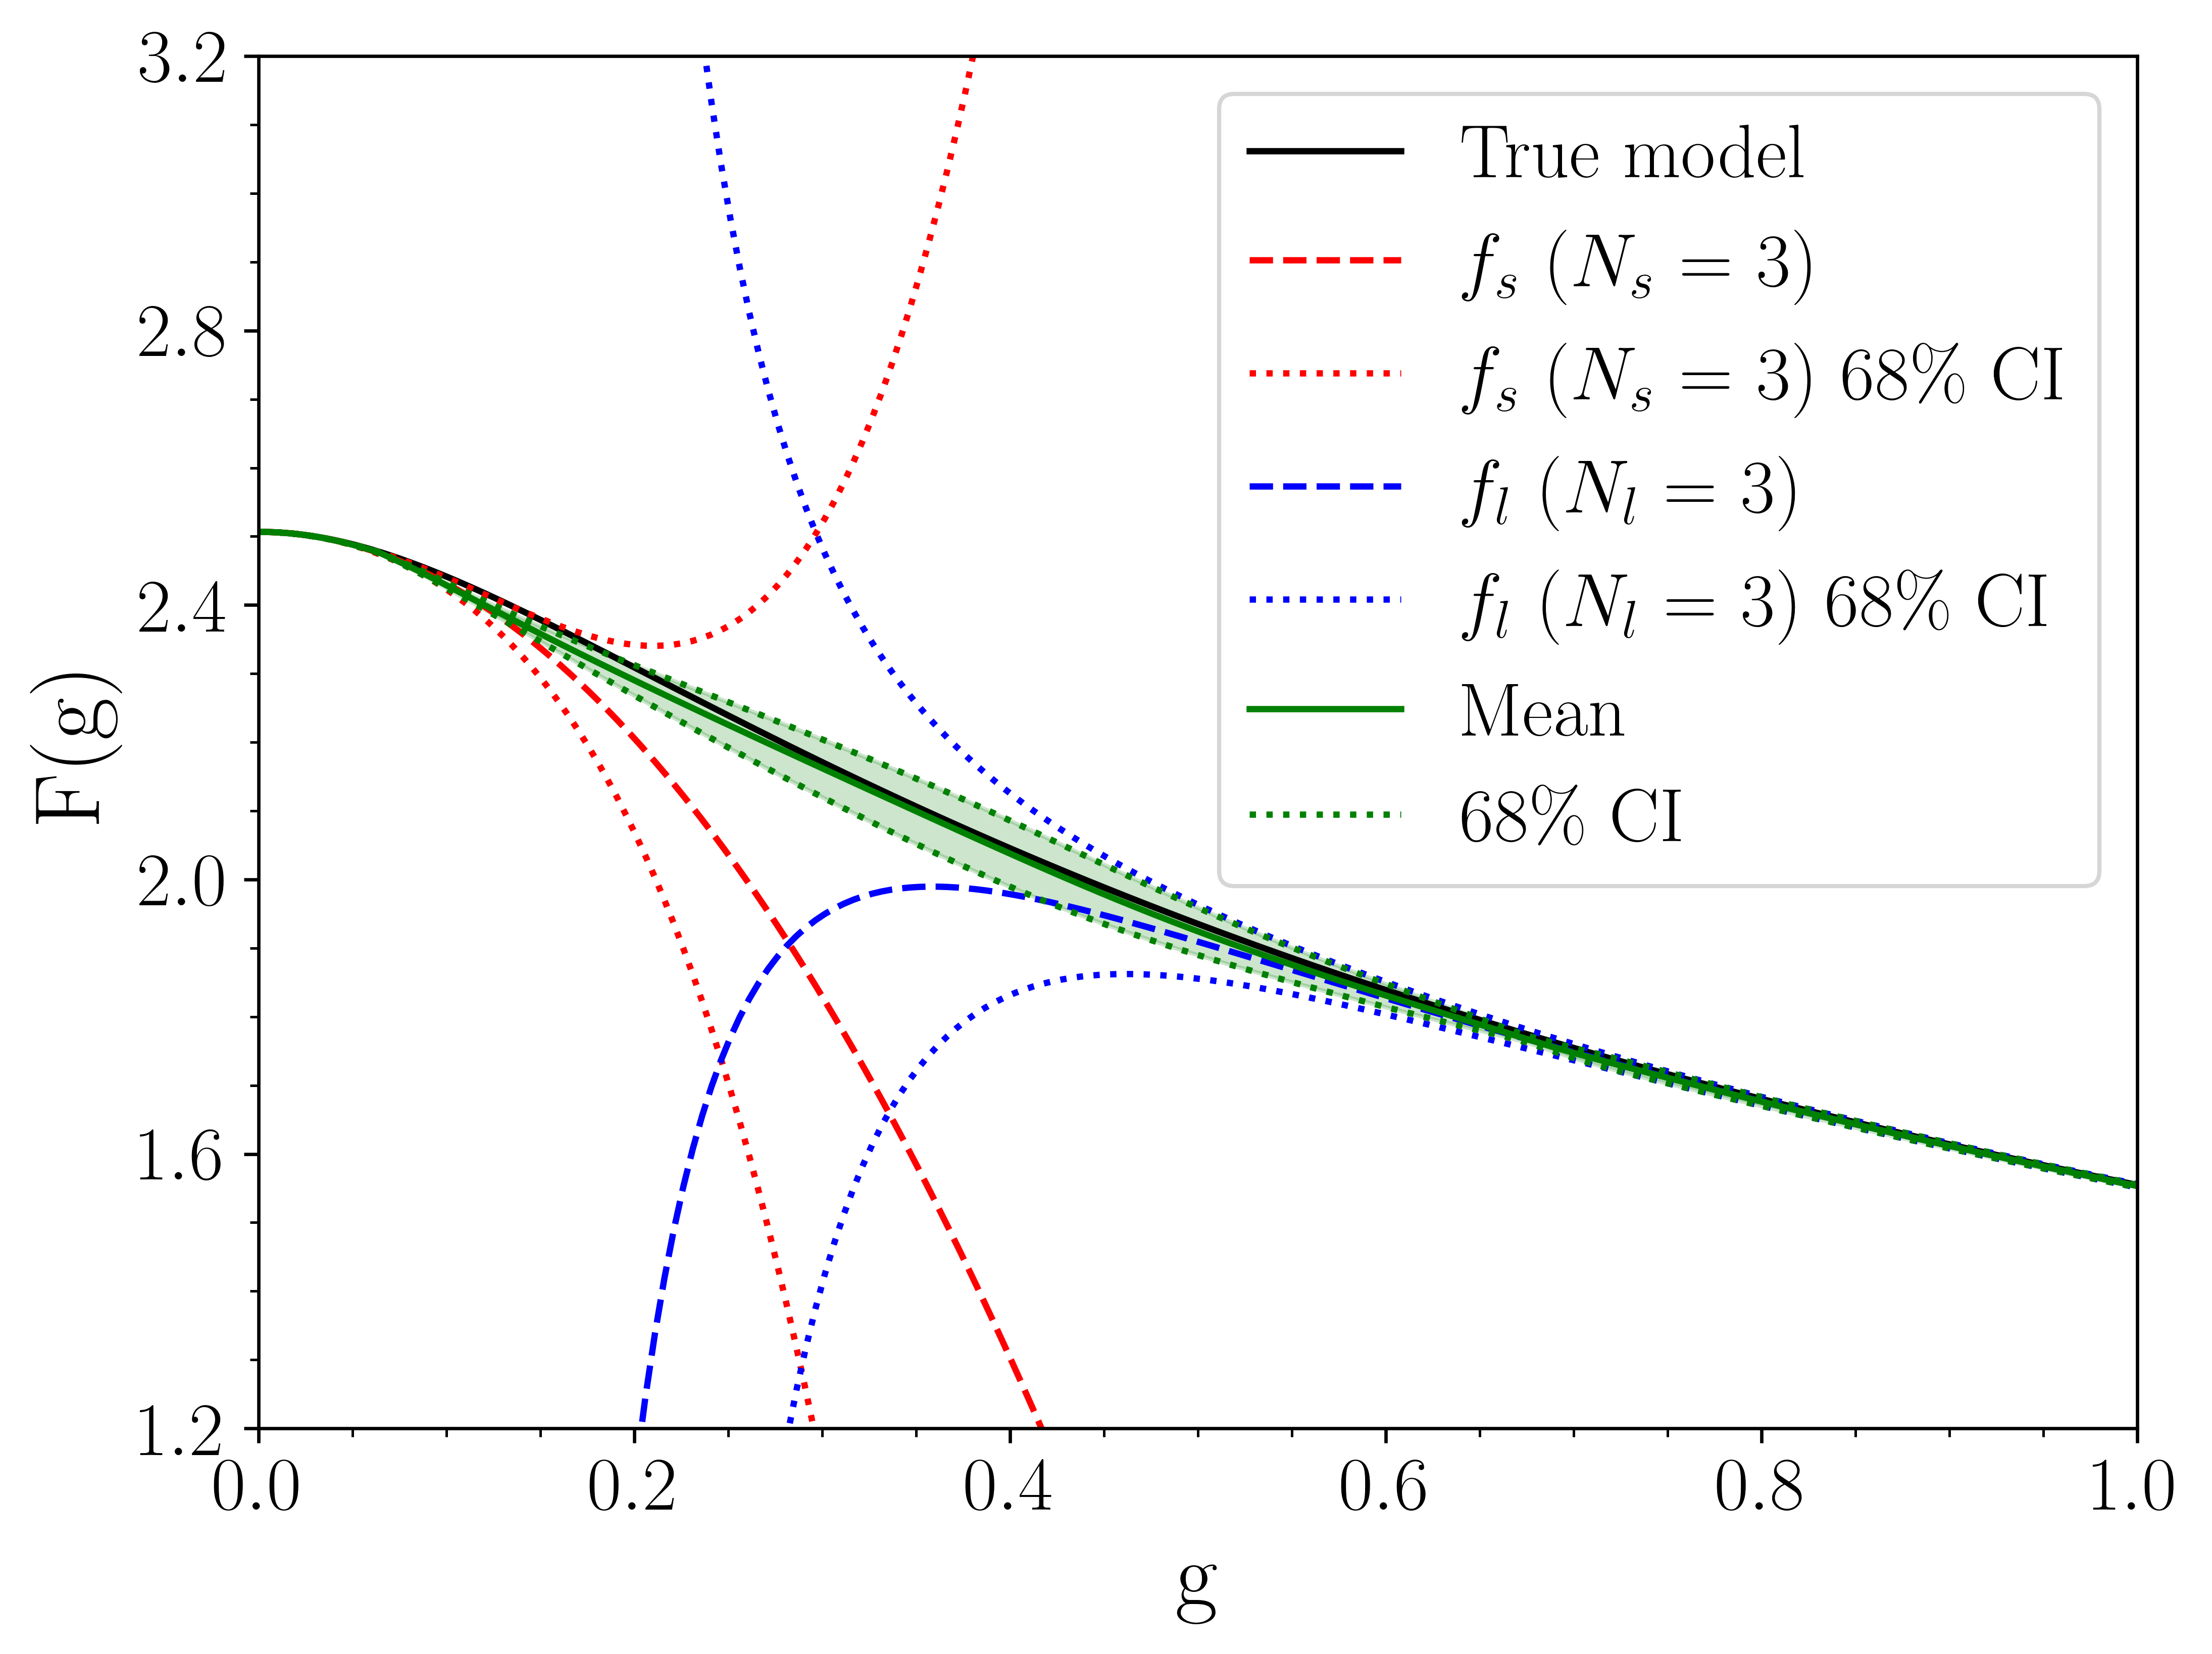

In [7]:
#call plot_mix() to mix in the GP
mixed_mean, mixed_intervals = obj1.plot_mix(g, plot_fdagger=True, plot_true=True, GP_mean=mean1, GP_var=np.square(sig1))

This result looks WAY better in the gap than the bivariate BMM did alone! Now let's directly compare to that case using our comparison function __subplot_mix()__, also found in the Bivariate() class.

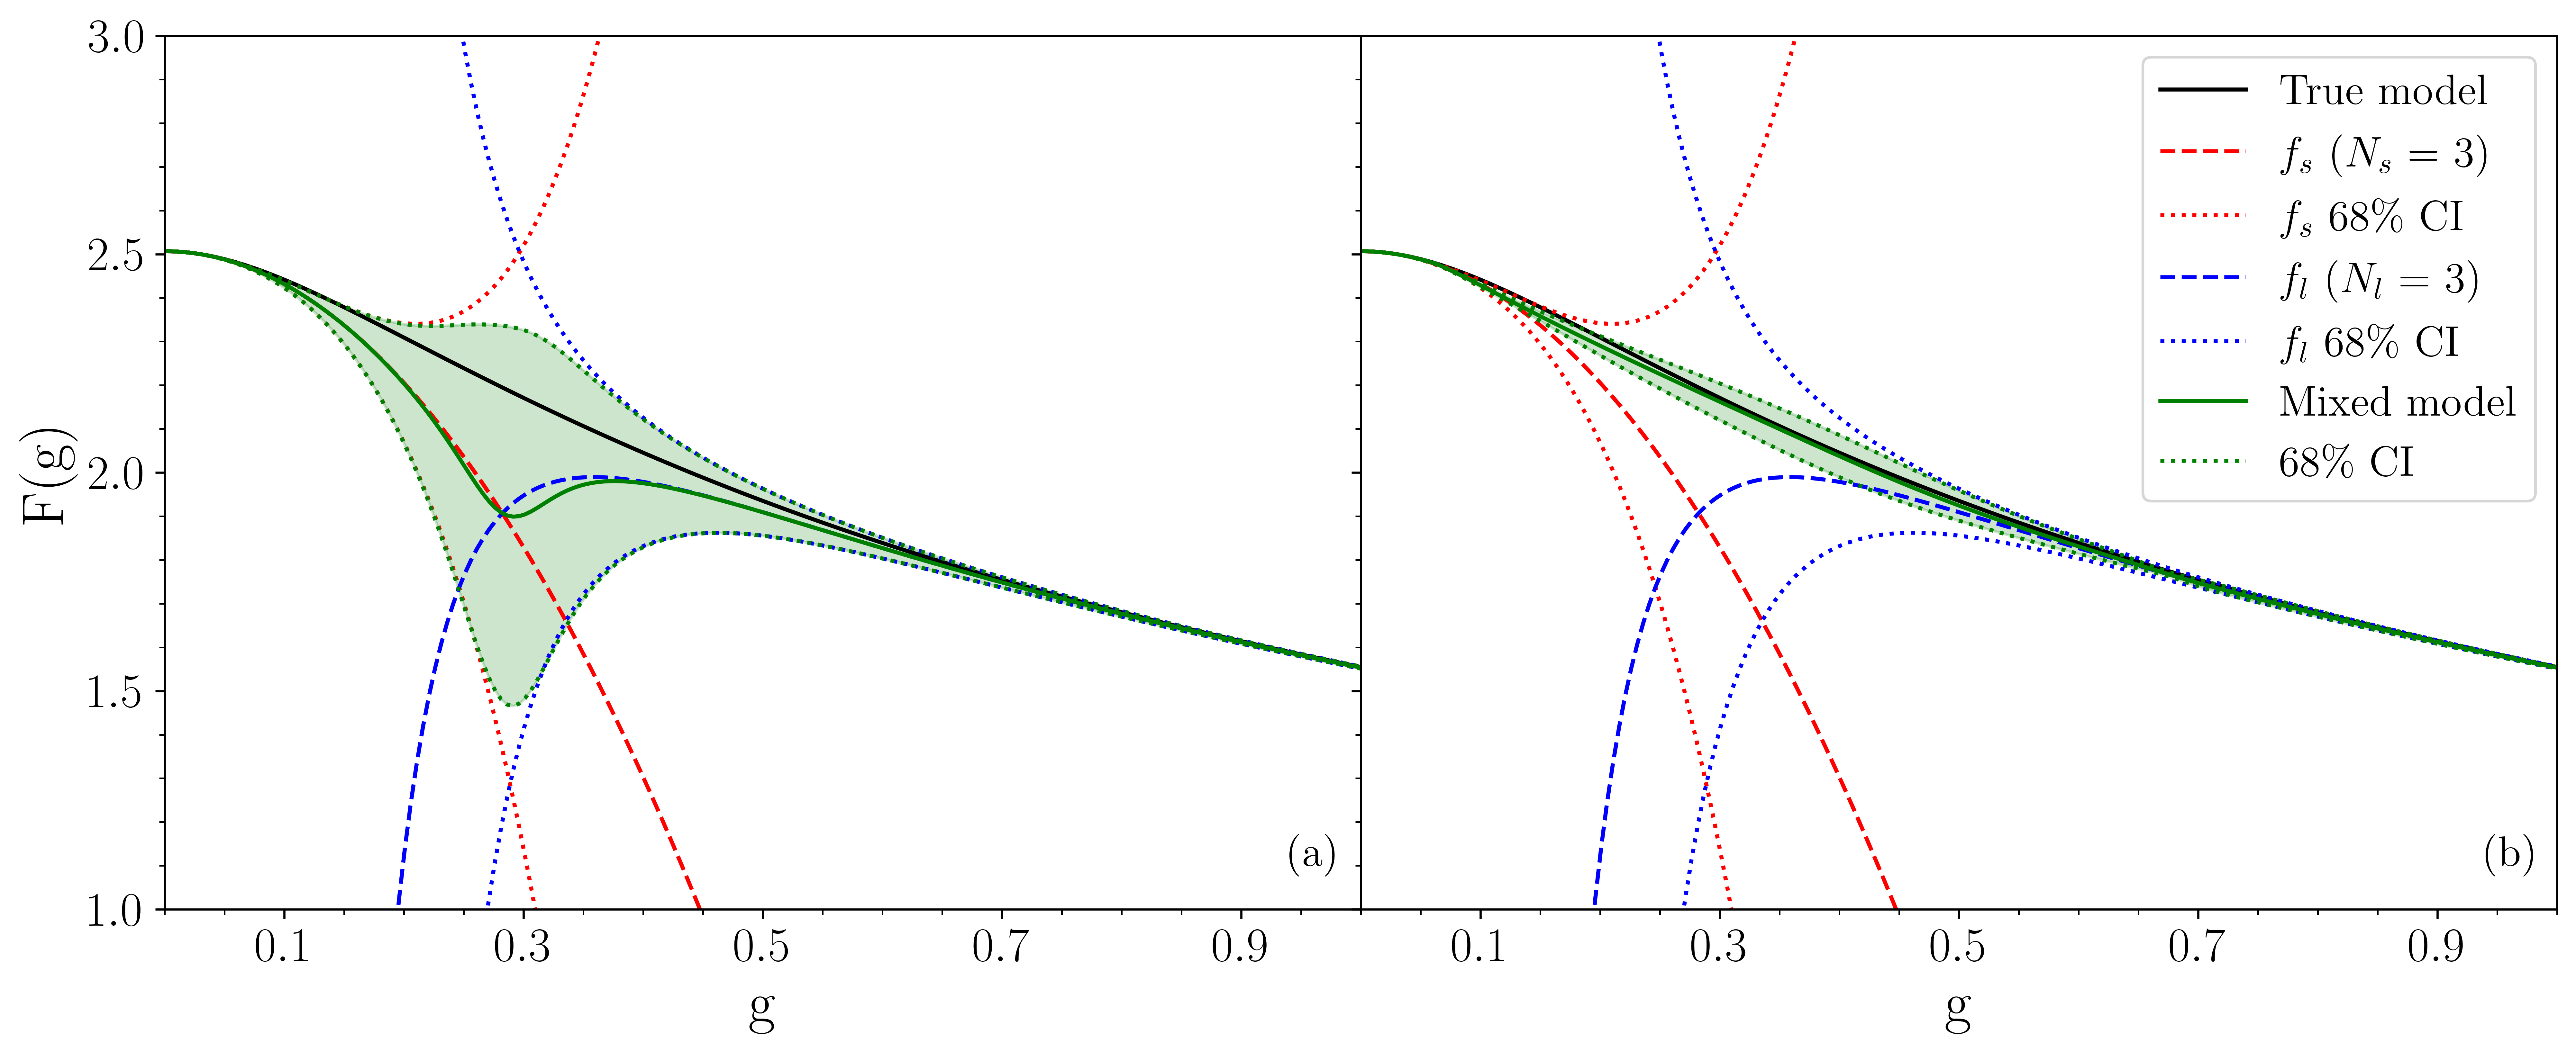

In [8]:
#call subplot_mix() and plot no GP results next to GP results
obj1.subplot_mix(g, GP_mean=mean1, GP_var=np.square(sig1))

The GP shows an obvious improvement in the gap in panel (b), as it follows the true curve quite well. The uncertainty band is also more believable, as it encompasses most of the true curve and does not allow for the possibility of any surprising result (like the dip seen in panel (a), which might be possible for a physical situation but not in a toy case where we know exactly what we are expecting to get). 

Let's check our results and see if we can truly trust them. One good way to do this is our diagnostic, the Mahalanobis distance. This is given by 

$$
\mathrm{D}^{2}_{\mathrm{MD}} = (y - m)^{T}\textit{K}^{-1}(y - m),
$$

where $y$ is the vector of true solutions at each point in $g$ that we are comparing to (our true curve), $m$ is the GP solution at each point in $g$, and $K^{-1}$ is the inverse of the GP covariance matrix, returned by our __validate()__ function above.

Let's try this calculation to see what we get for the Mahalanobis distance. We will use 3 points to calculate it, as our lengthscale is quite long, and we can only put a few points in it without $K$ becoming a singular matrix. We will also choose 1000 draws from our GP to compare our Mahalanobis distance to a reference distribution.

Location of MD points in g:  [0.2977394  0.53015122 0.76256305]
The squared Mahalanobis distance: 0.24526671718775314


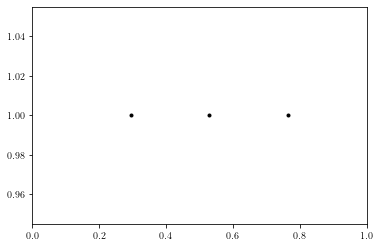

In [9]:
#calculate the Mahalanobis points
md_g, md_mean, md_sig, md_cov = obj1.MD_set(pts=3)

#use the points to calculate the Mahalanobis distance for our GP
md_gp, md_ref = obj1.md_squared(md_g, md_mean, md_cov, n_curves=1000)

Now that we have all of this information, let's plot the histogram of our GP curves to double check that we are indeed getting the $\chi^{2}$ distribution shape we expect from our GP draws. 

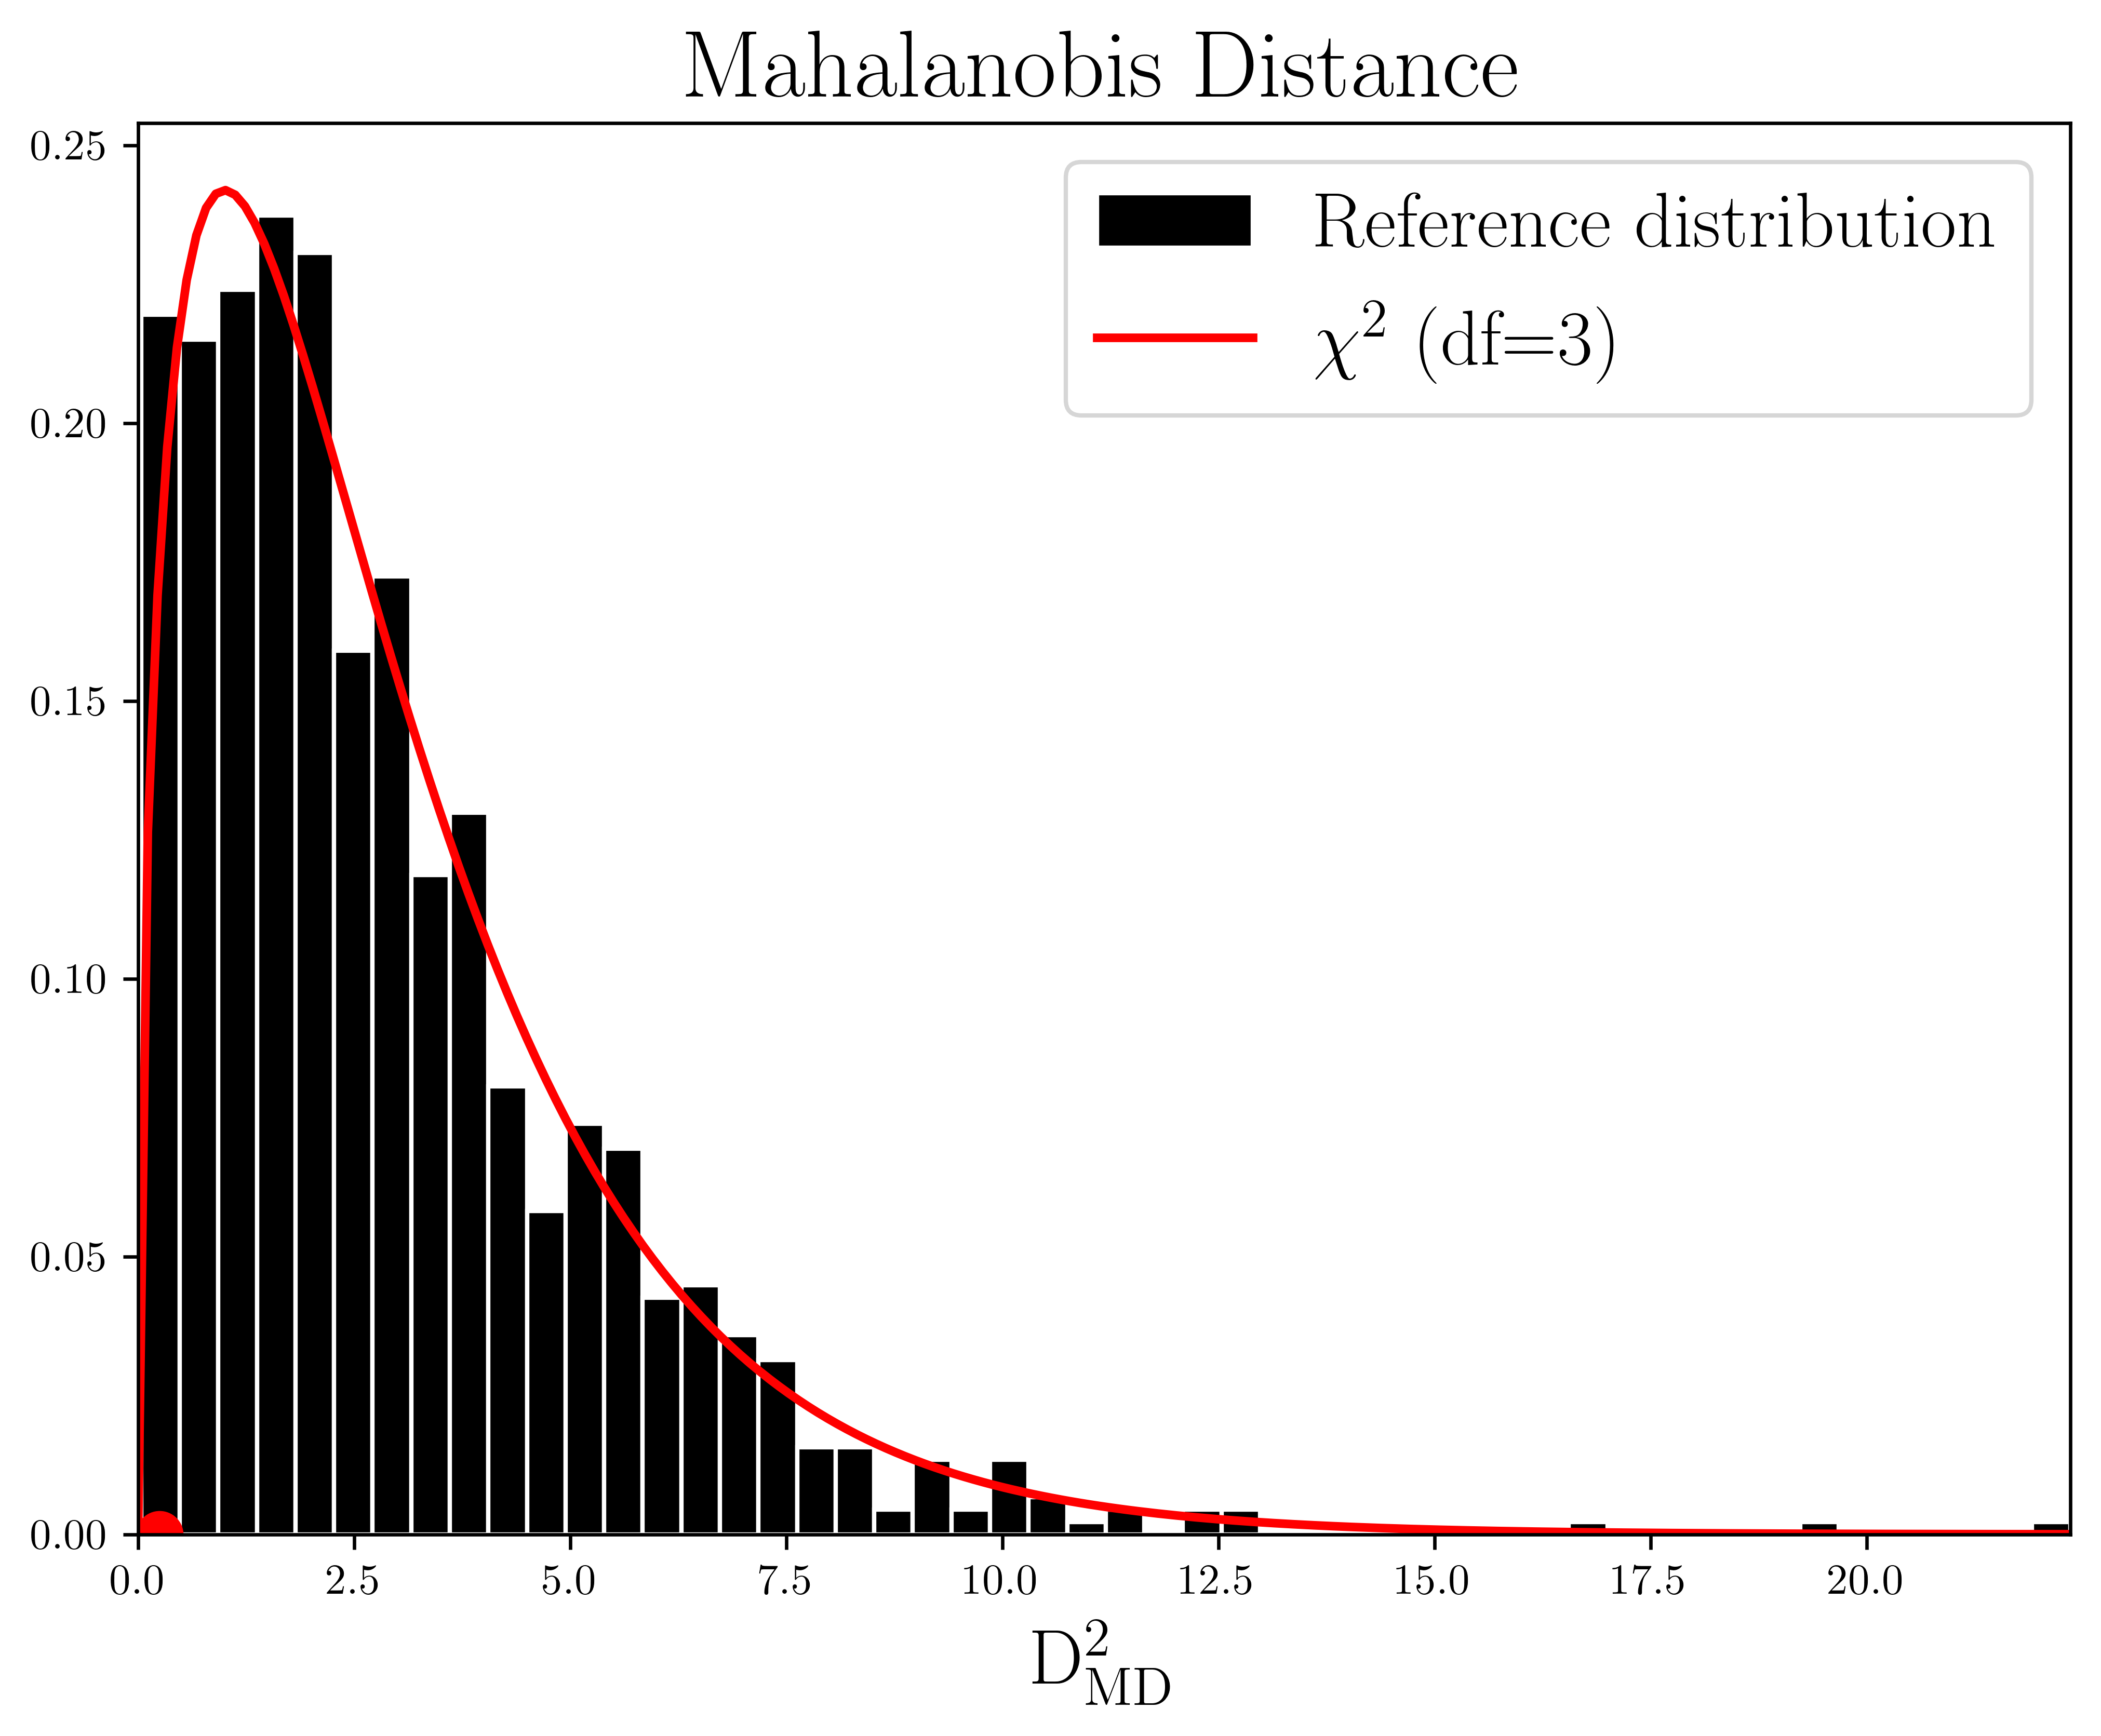

In [10]:
#call 
obj1.md_plotter(md_gp, md_ref, hist=True)

This looks good; the red dot at the low end is the squared MD result from our GP. It is close to 0, indicating that the result we get is not too far from the true curve, and it is within the expectation from the $\chi^{2}$, so we have a good prediction for our mixed model.

Now let's look at what the weights of each function look like (the normalized precisions of each model) across the input space, $g$. The actual weight values are contained within a class variable in the __fdagger()__ function, under the name __var_weights__. 

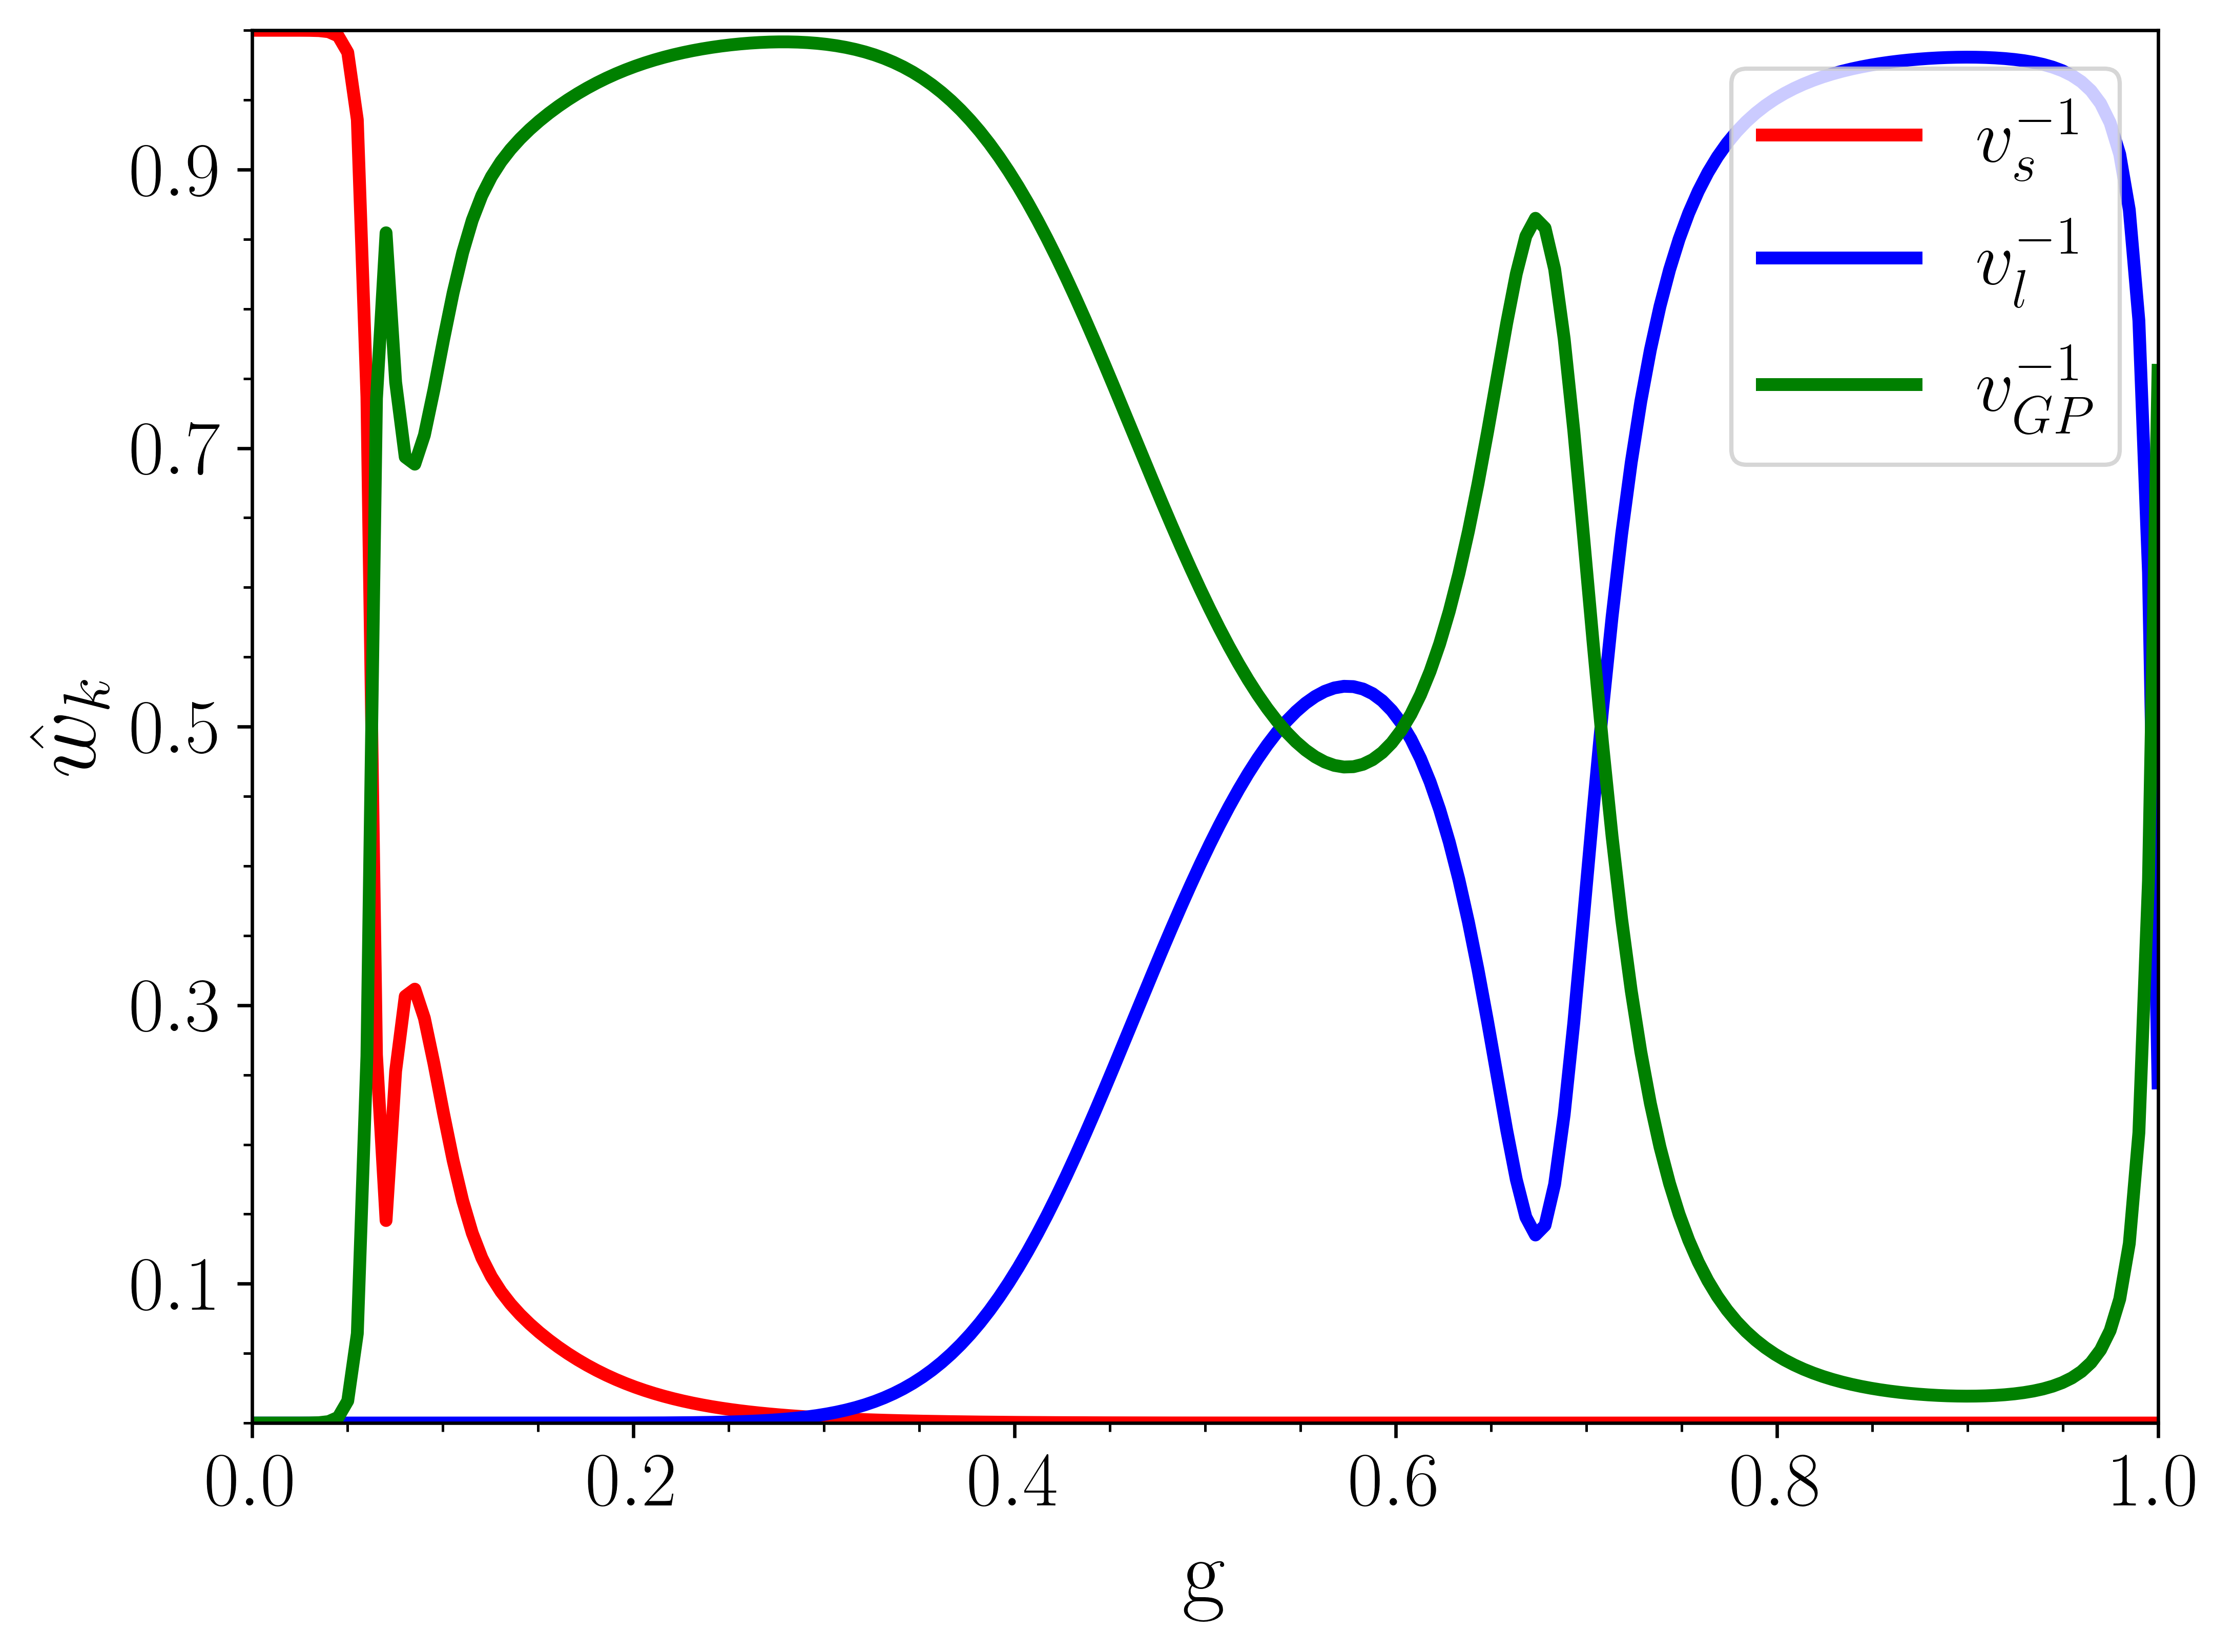

In [11]:
#pull weights out of fdagger()
vargp1 = obj1.var_weights[0]
vargp2 = obj1.var_weights[1]
vargp3 = obj1.var_weights[2]

#set up figure
fig = plt.figure(figsize=(8,6), dpi=600)
ax = plt.axes()
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.locator_params(nbins=5)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim(0.0,1.0)
ax.set_ylim(0.0,1.0)
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9])

#labels and true model
ax.set_xlabel('g', fontsize=22)
ax.set_ylabel(r'$\hat{w}_{k}$', fontsize=22)

ax.plot(g, vargp1, 'r', linewidth=3, label=r'$v_{s}^{-1}$')
ax.plot(g, vargp2, 'b', linewidth=3, label=r'$v_{l}^{-1}$')
ax.plot(g, vargp3, 'g', linewidth=3, label=r'$v_{GP}^{-1}$')

ax.legend(fontsize=18, loc='upper right')
plt.show()

This is quite an interesting shape; it shows that the GP (the green curve) takes over in the gap in the mixing process, but then drops in favour of the large-$g$ expansion (blue curve) at the edge of the gap, but then comes back as the dominant model after this for a little bit before mostly surrendering to the large-$g$ expansion. It appears that the jumps in the weights are at the values of $g$ that are close to the training points. 

Now let's repeat the process of mixing our models for $N_{s} = N_{l} = 2$ and $N_{s} = N_{l} = 5$, as in Fig. 7 in the paper.

Which error model do you want to use, uninformative or informative? (u/i)i
Using the informative error model.
Enter a value for nu (standard: 0.5, 1.5, 2.5).1.5
Initializing standard Constant * Matern kernel.
Current training method: 2
Gaussian process parameters: 2.44**2 * Matern(length_scale=2.19, nu=1.5)


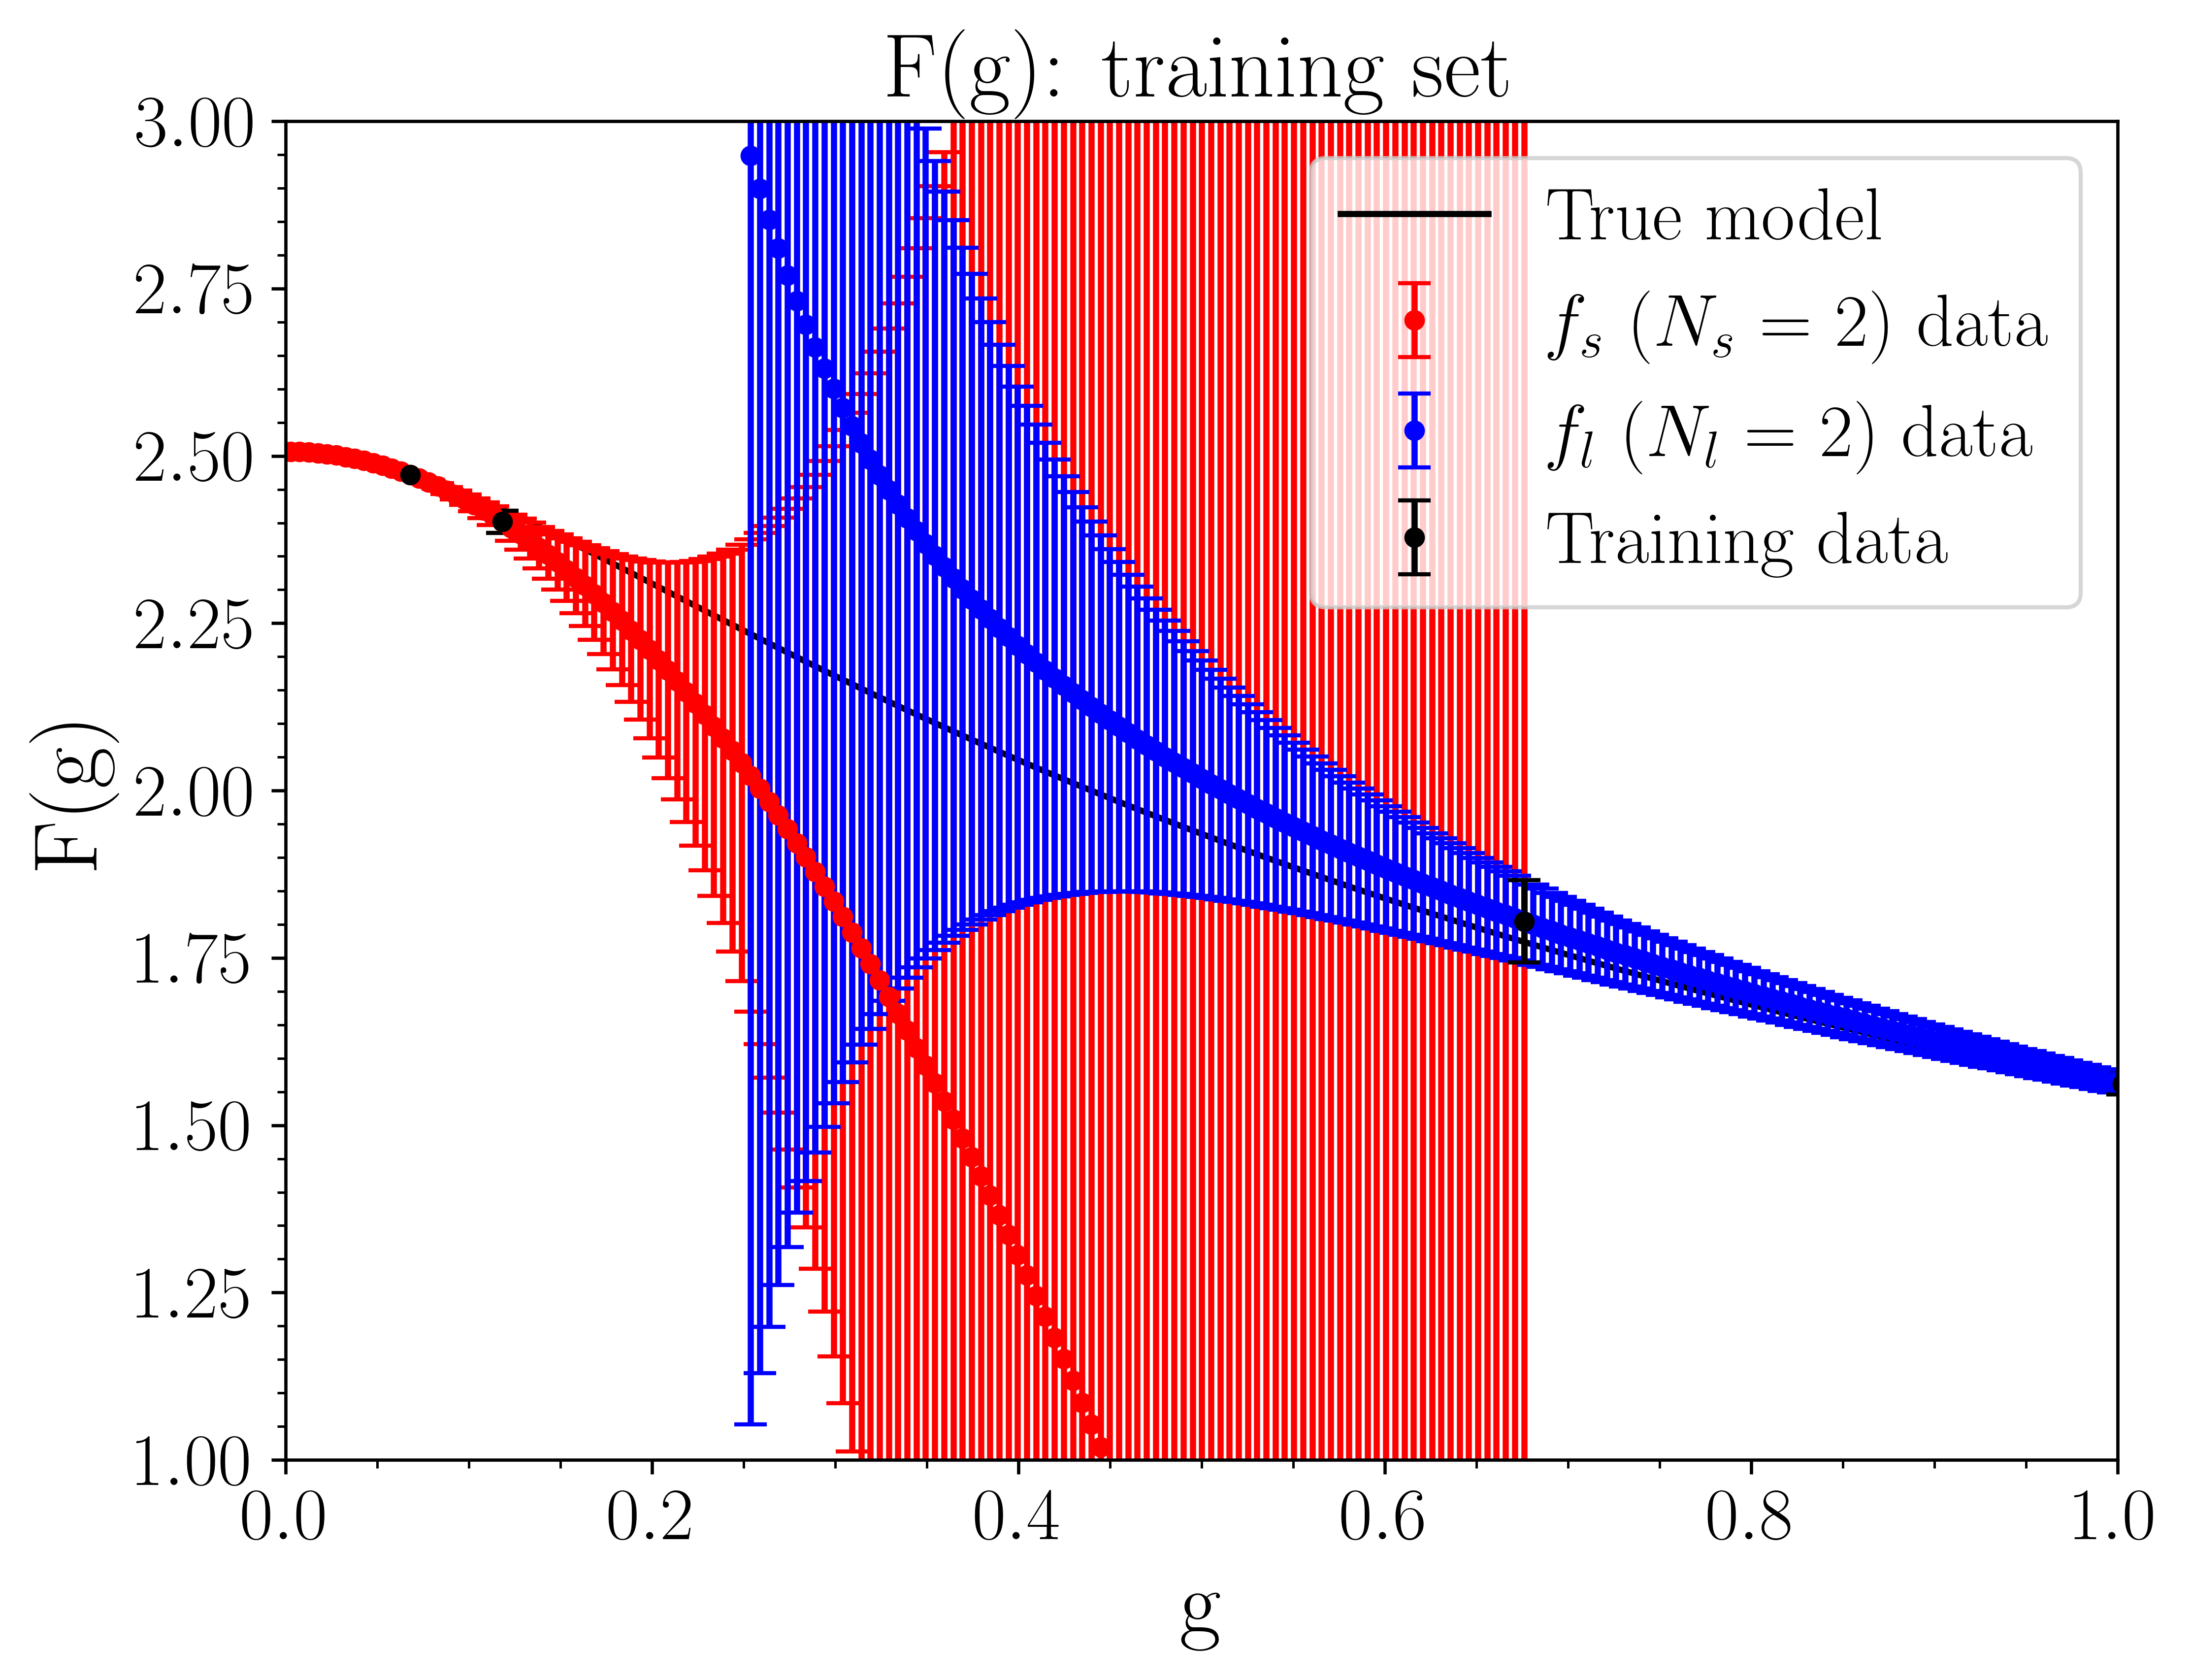

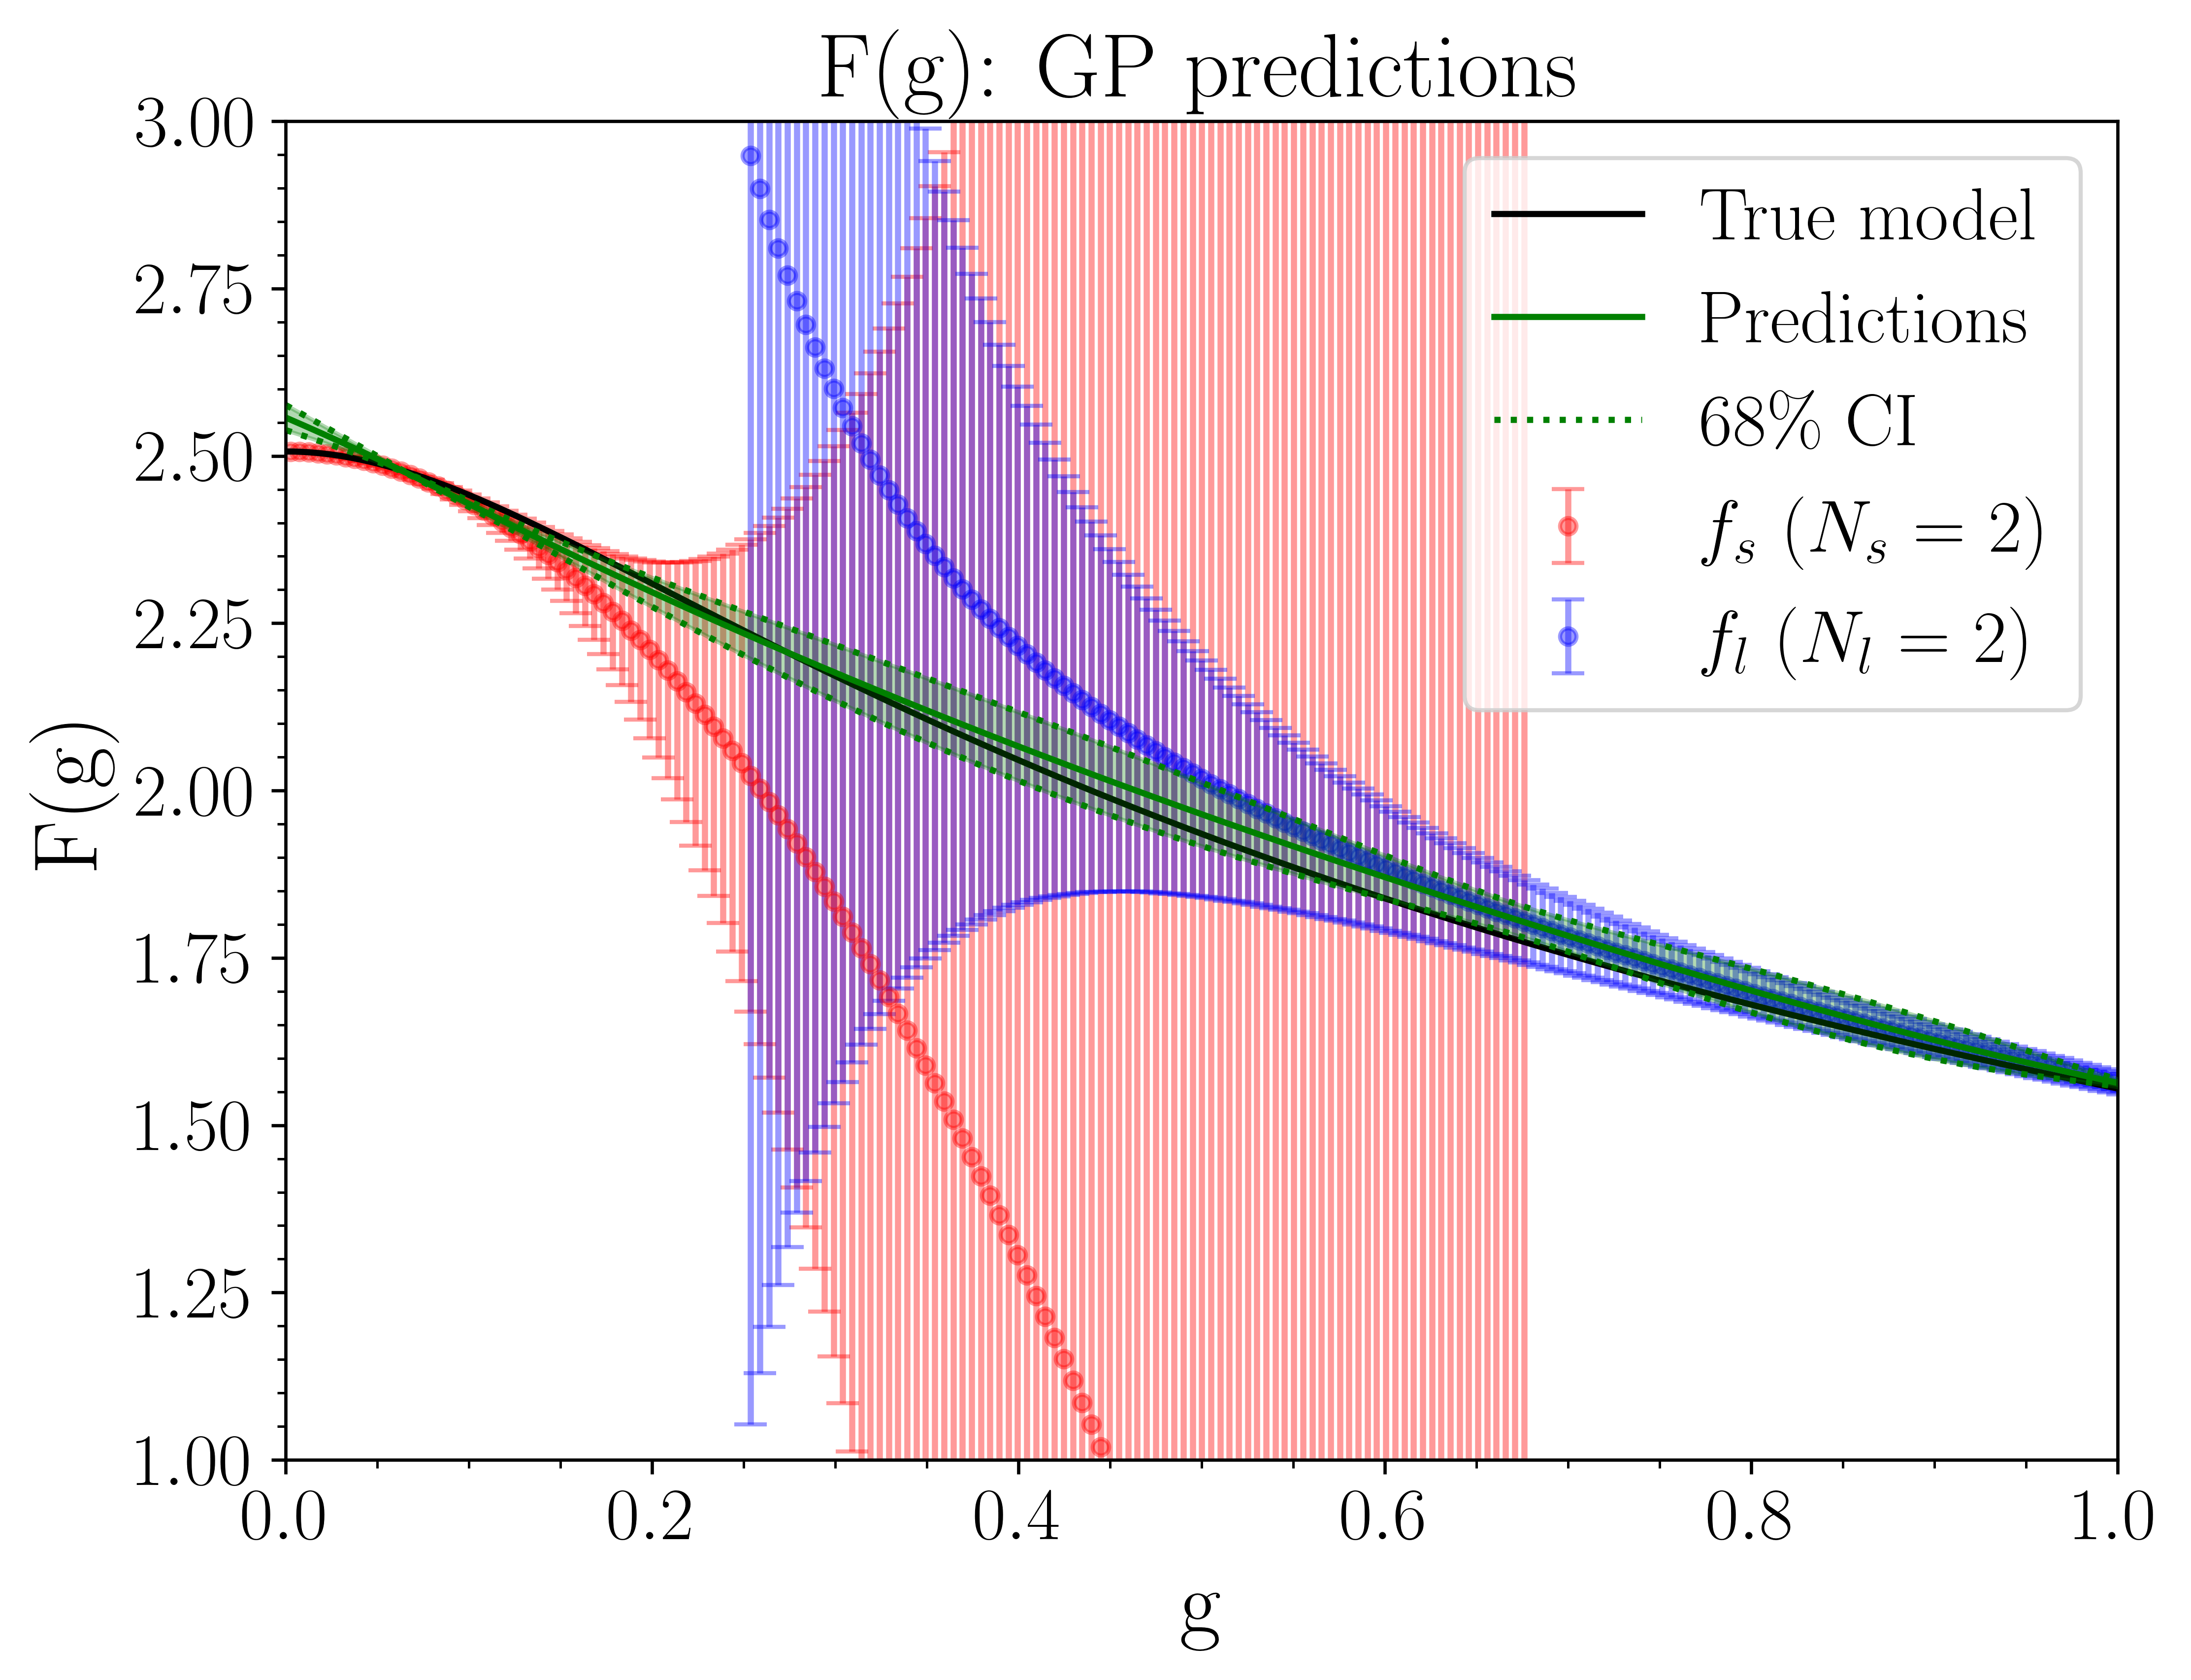

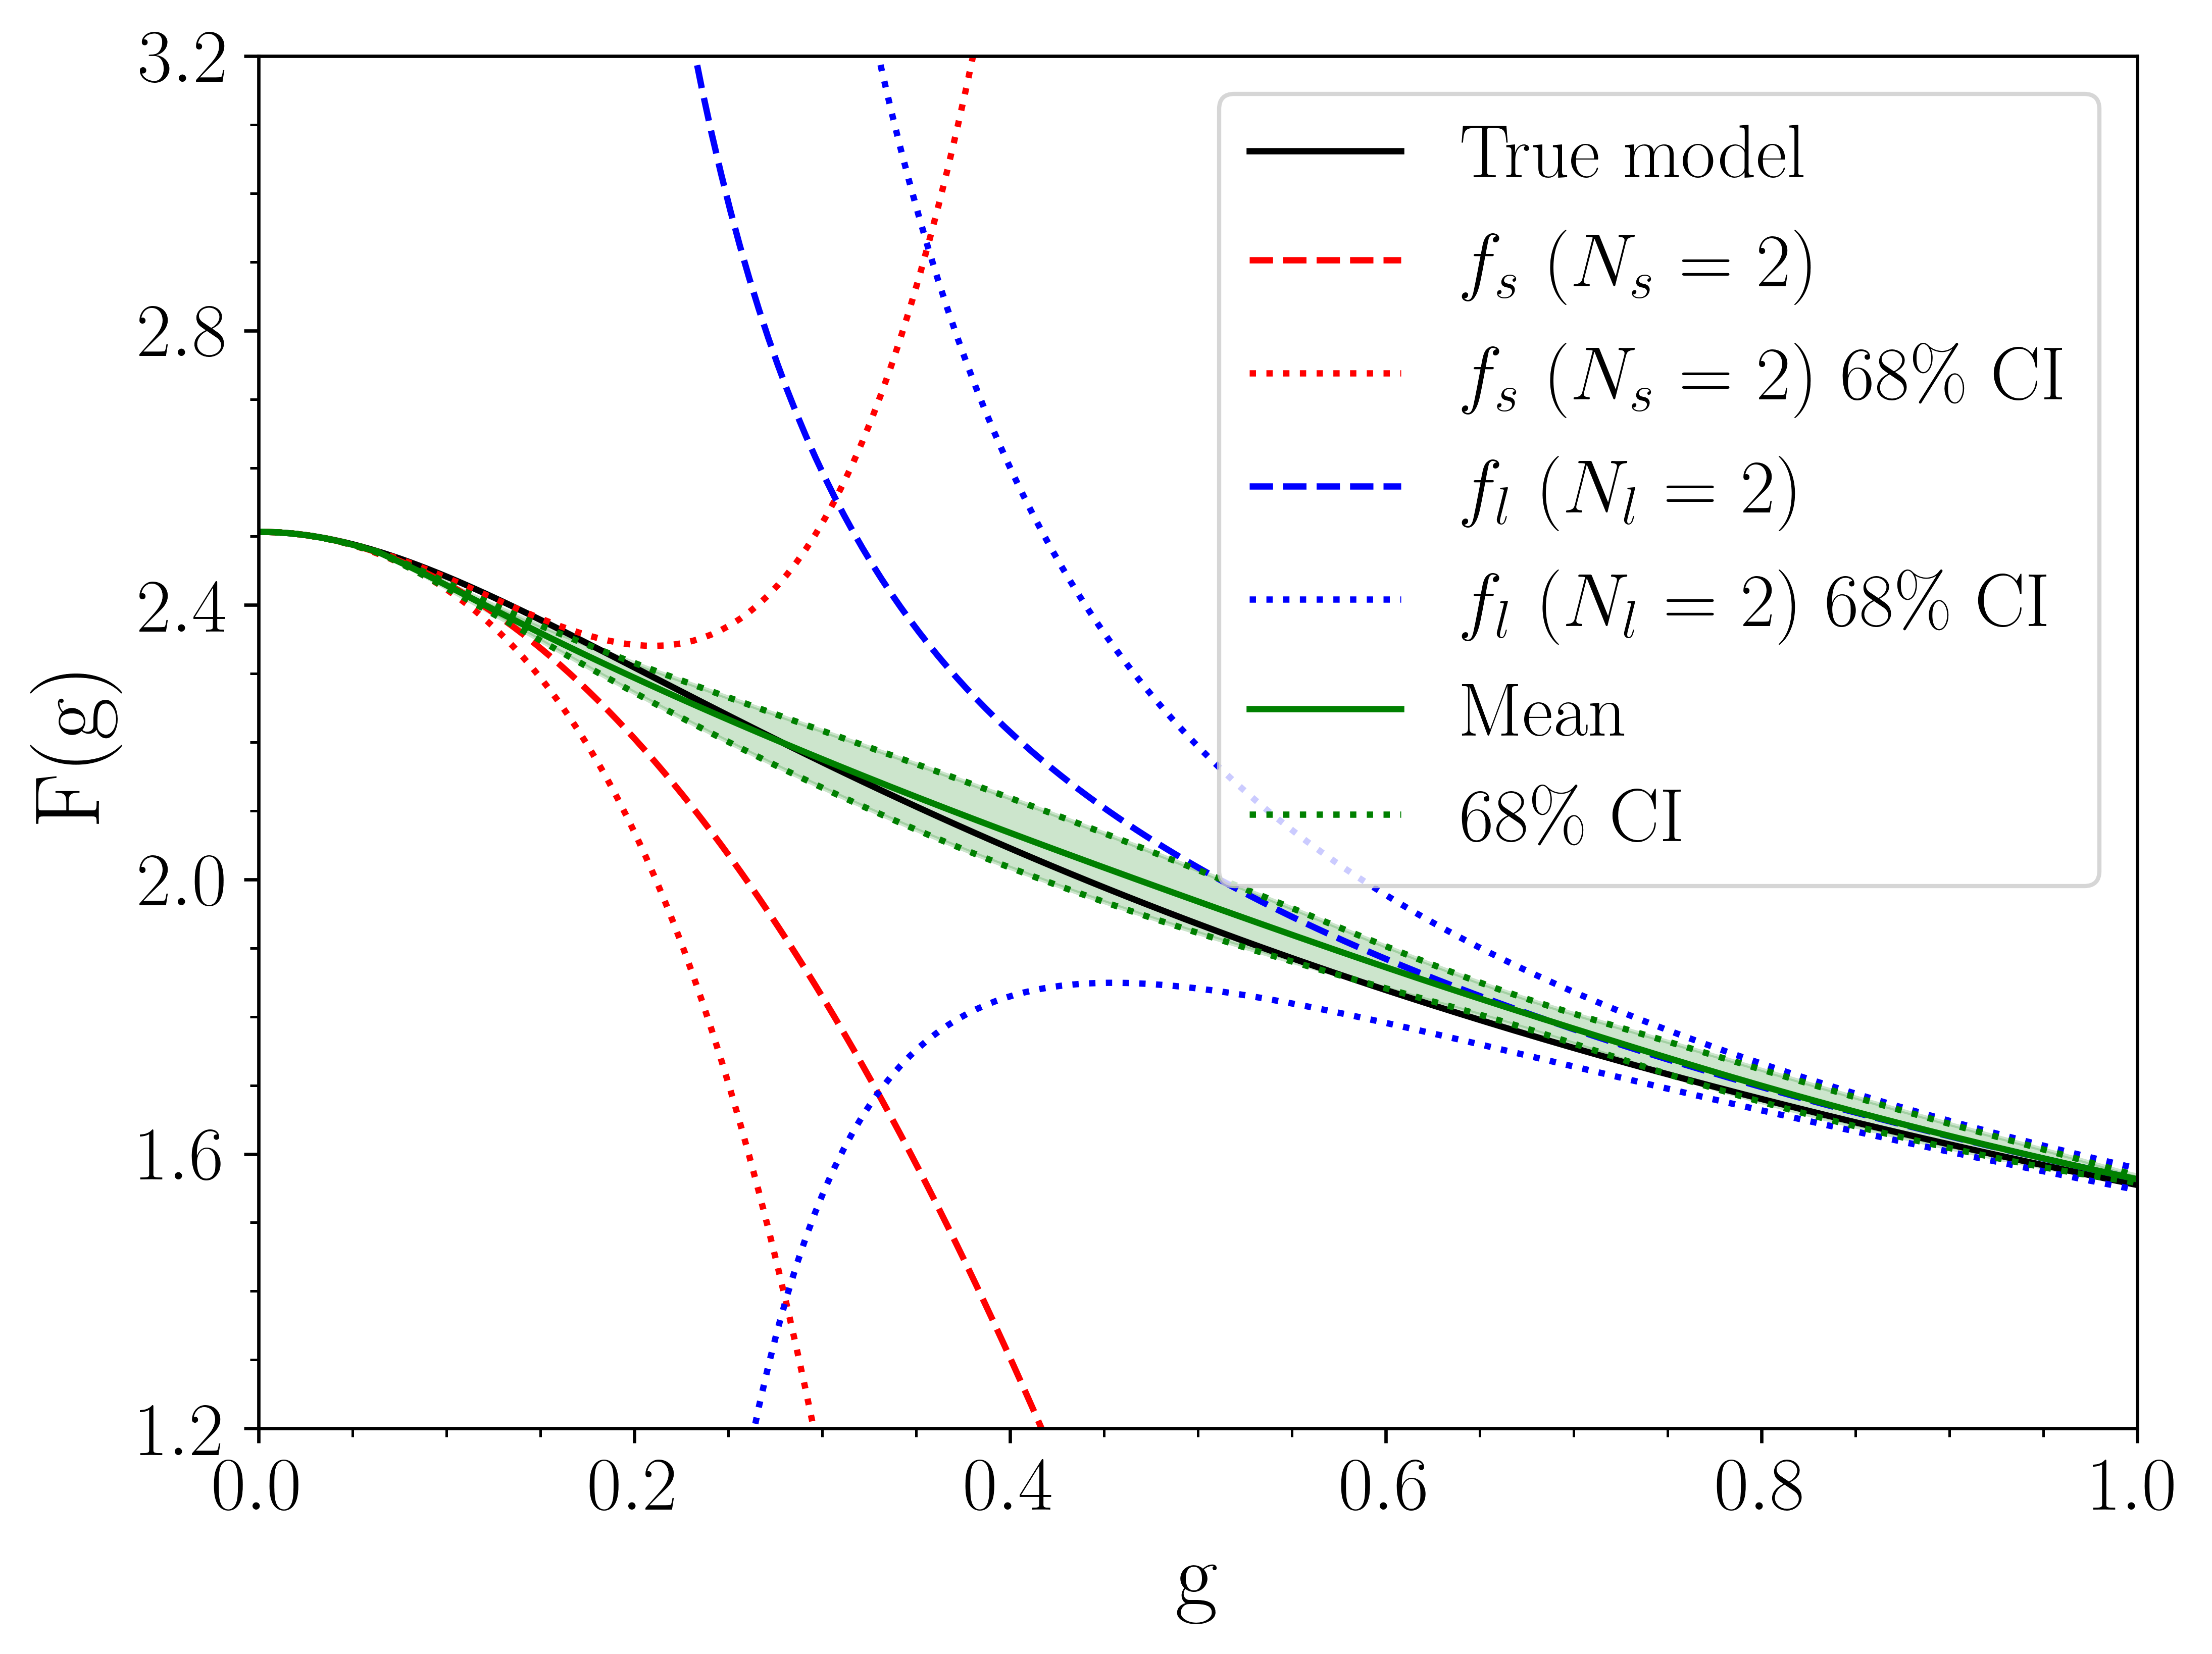

In [12]:
#new object for N_s = N_l = 2 and same steps as before
ns = 2
nl = 2
obj2 = GP(g, ns, nl, ci=68, kernel="Matern")
obj_tr2 = obj2.training()
mean2, sig2, cov2 = obj2.validate()
mixed_mean2, mixed_intervals2 = obj2.plot_mix(g, plot_fdagger=True, plot_true=True, GP_mean=mean2, GP_var=np.square(sig2))

Which error model do you want to use, uninformative or informative? (u/i)i
Using the informative error model.
Enter a value for nu (standard: 0.5, 1.5, 2.5).1.5
Initializing standard Constant * Matern kernel.
Current training method: 2
Gaussian process parameters: 1.43**2 * Matern(length_scale=0.889, nu=1.5)


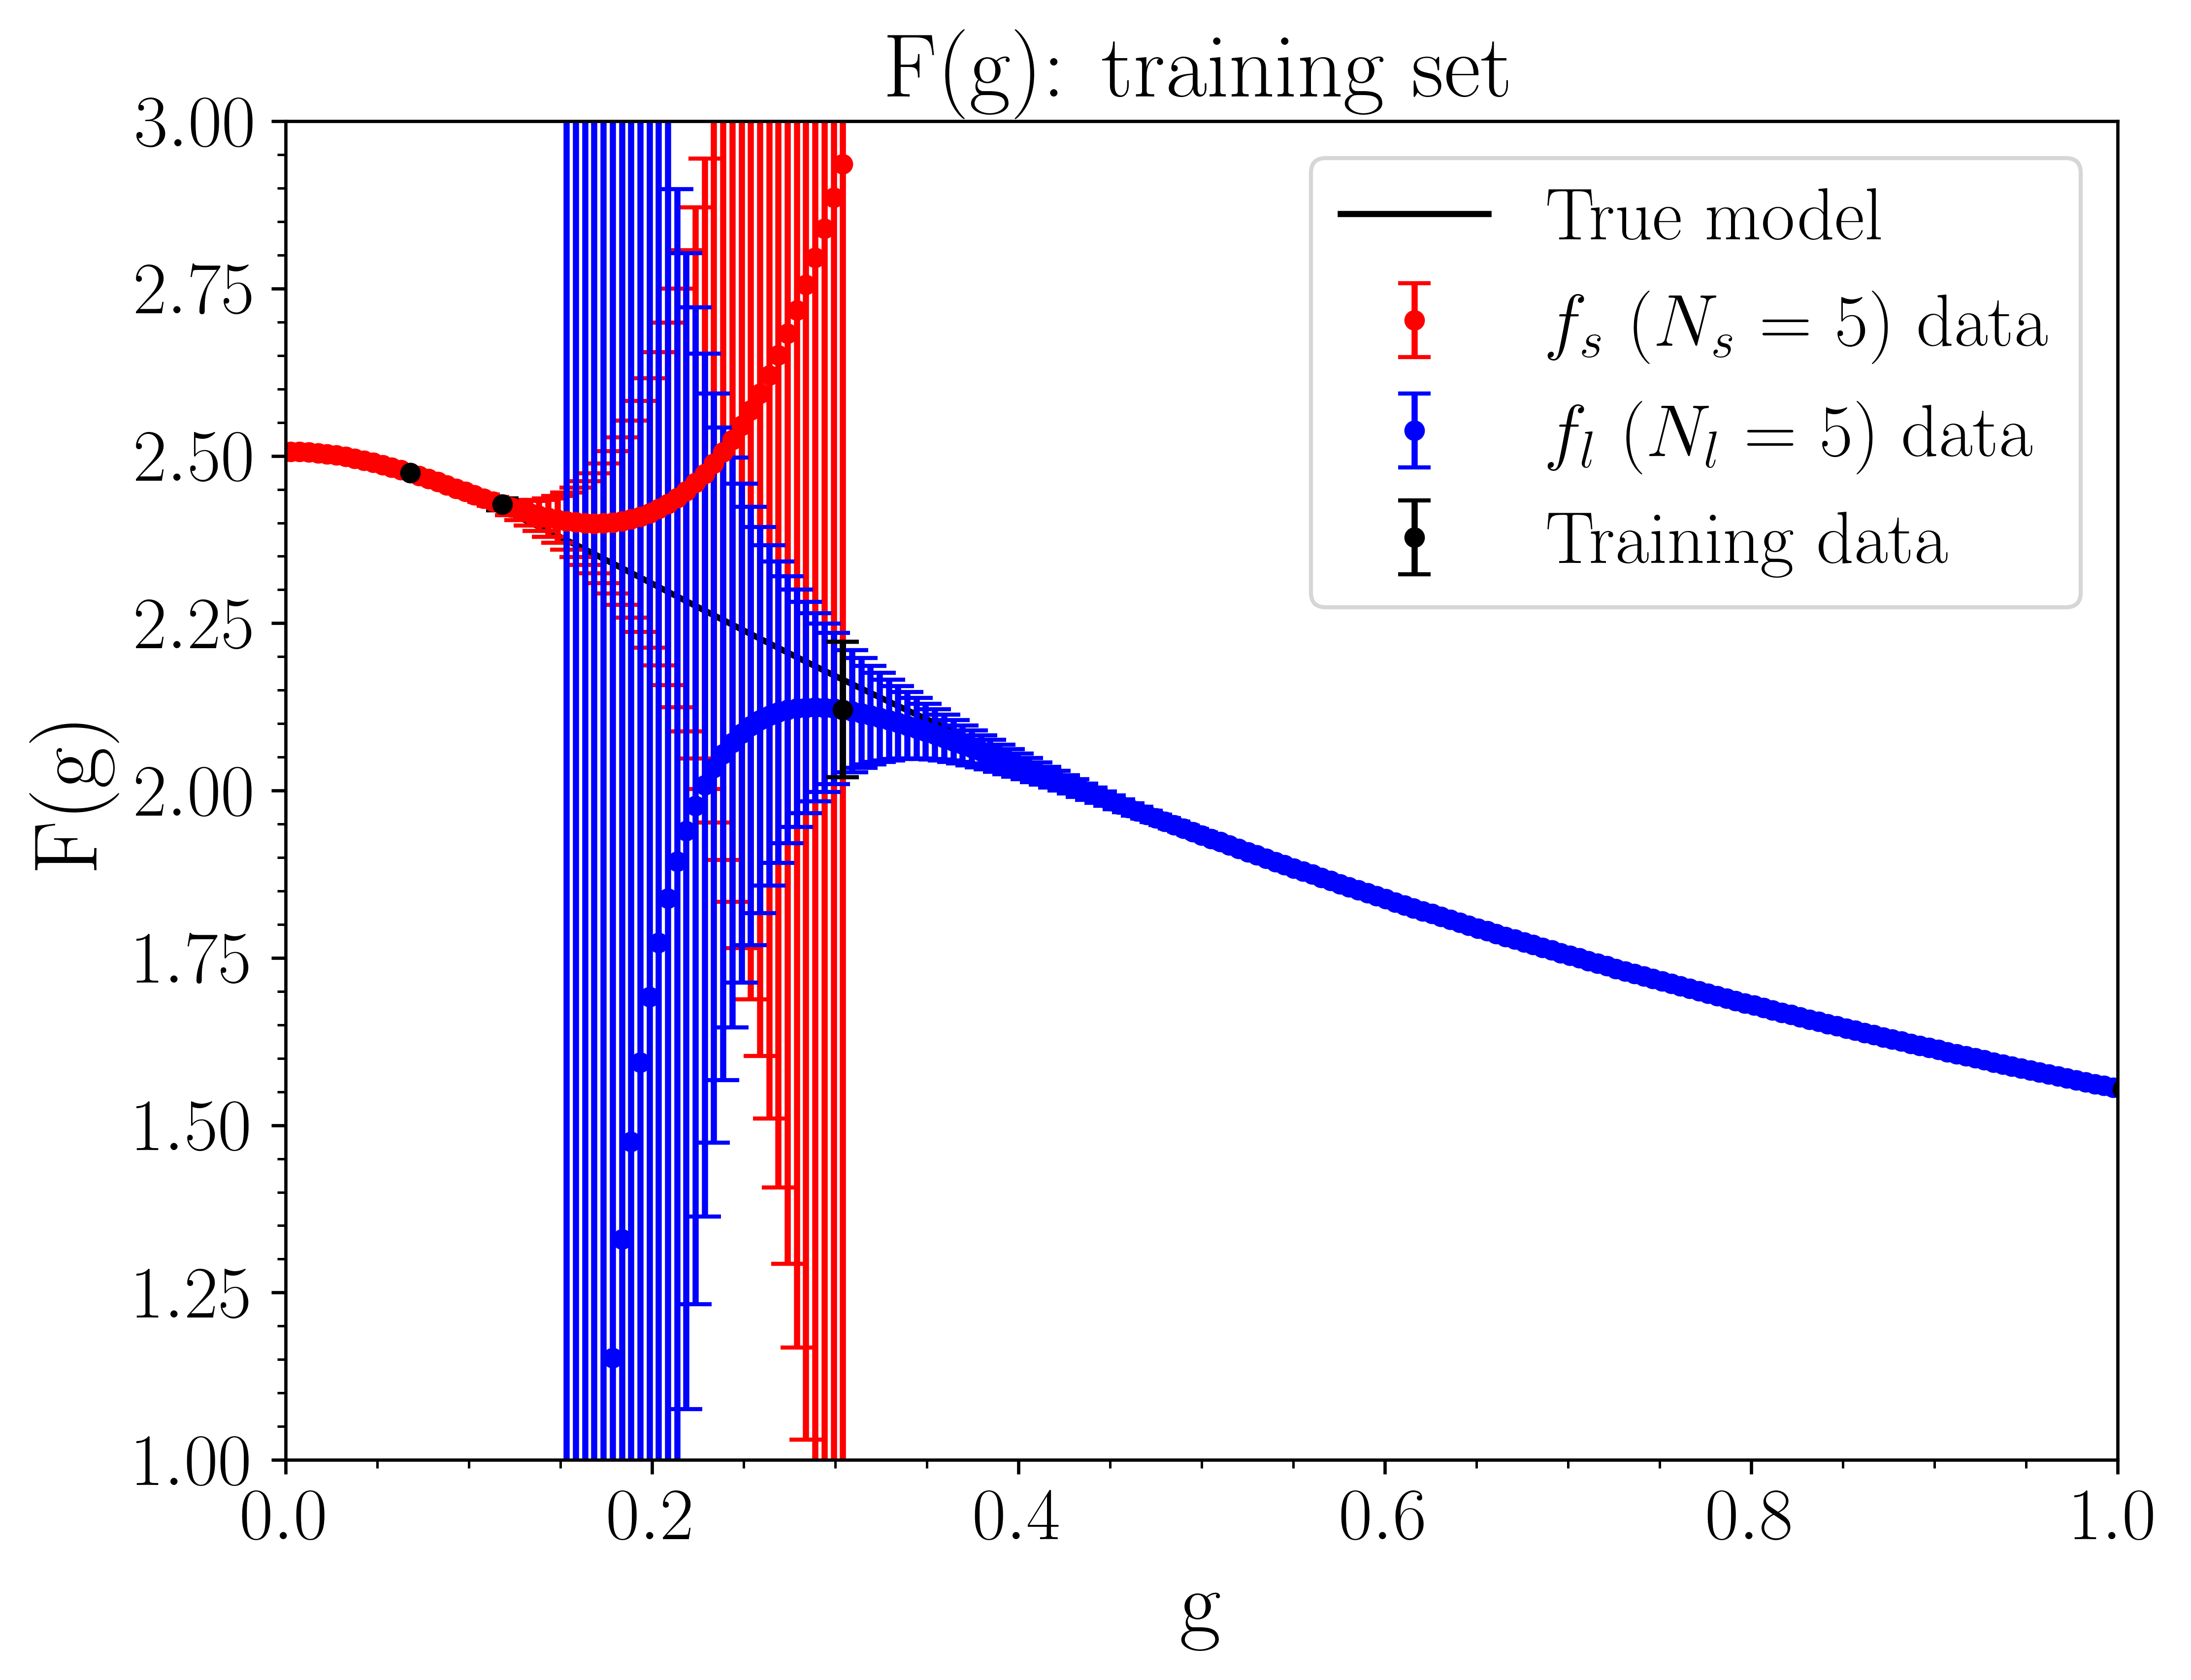

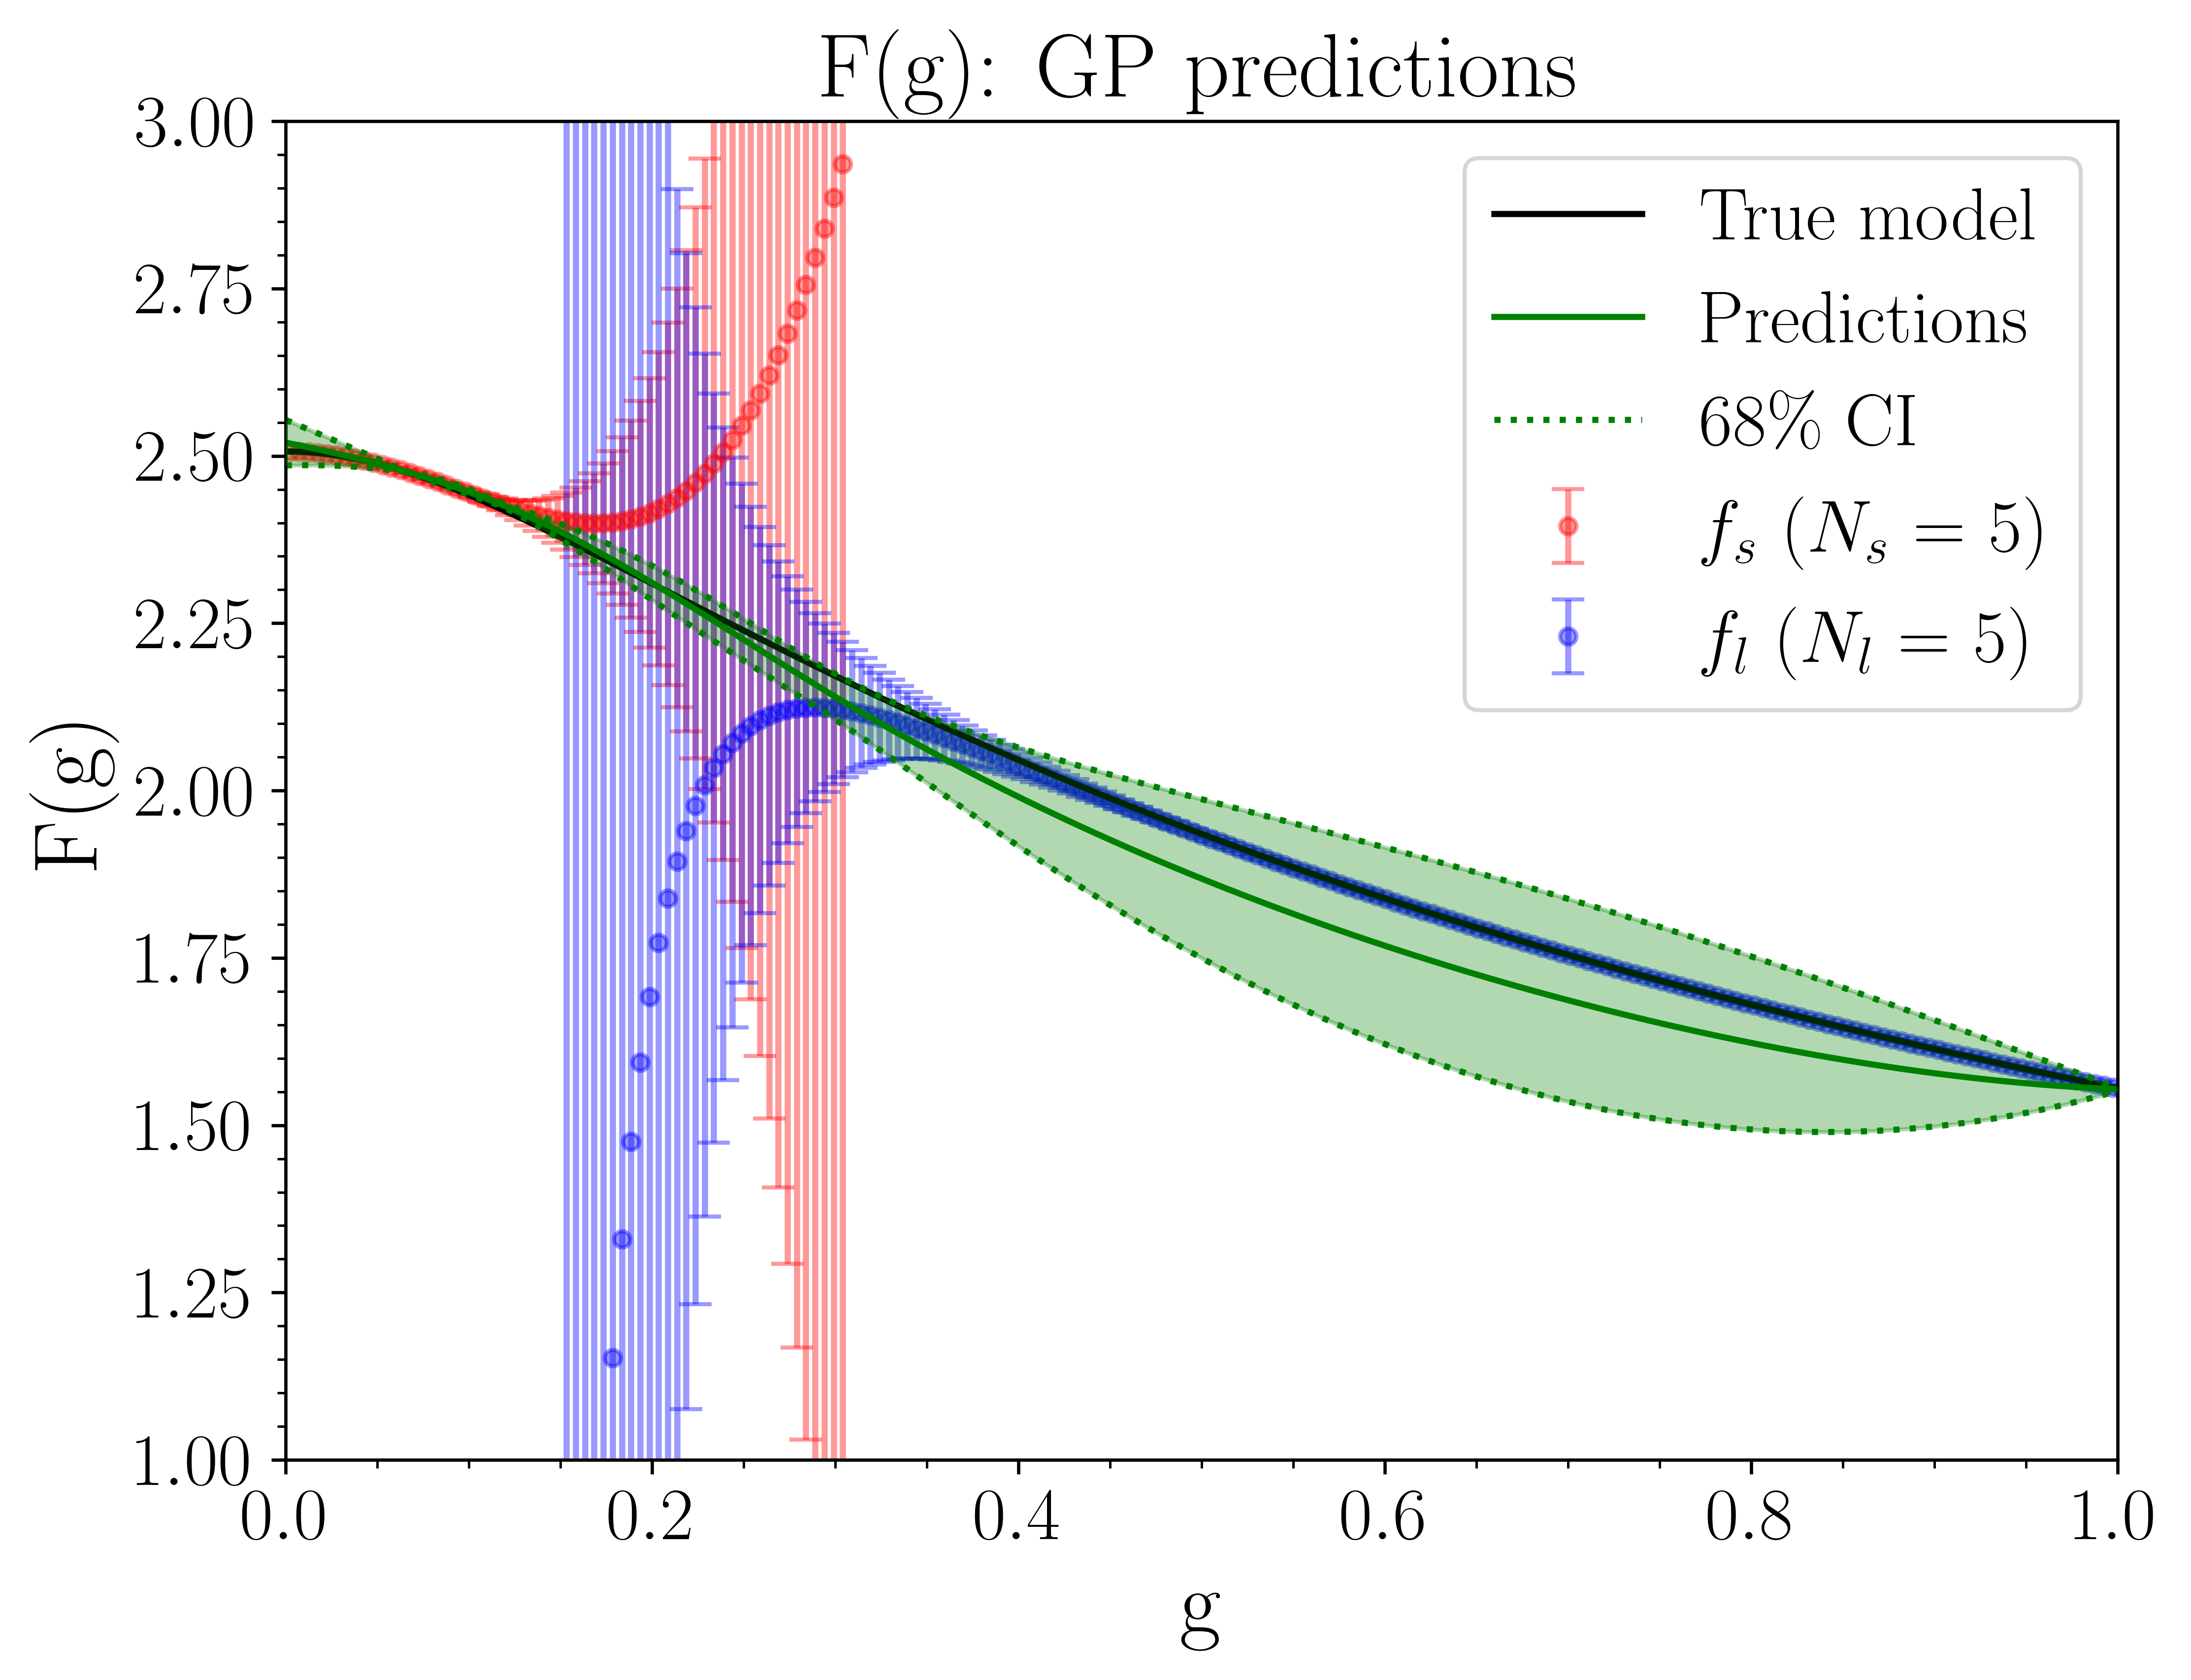

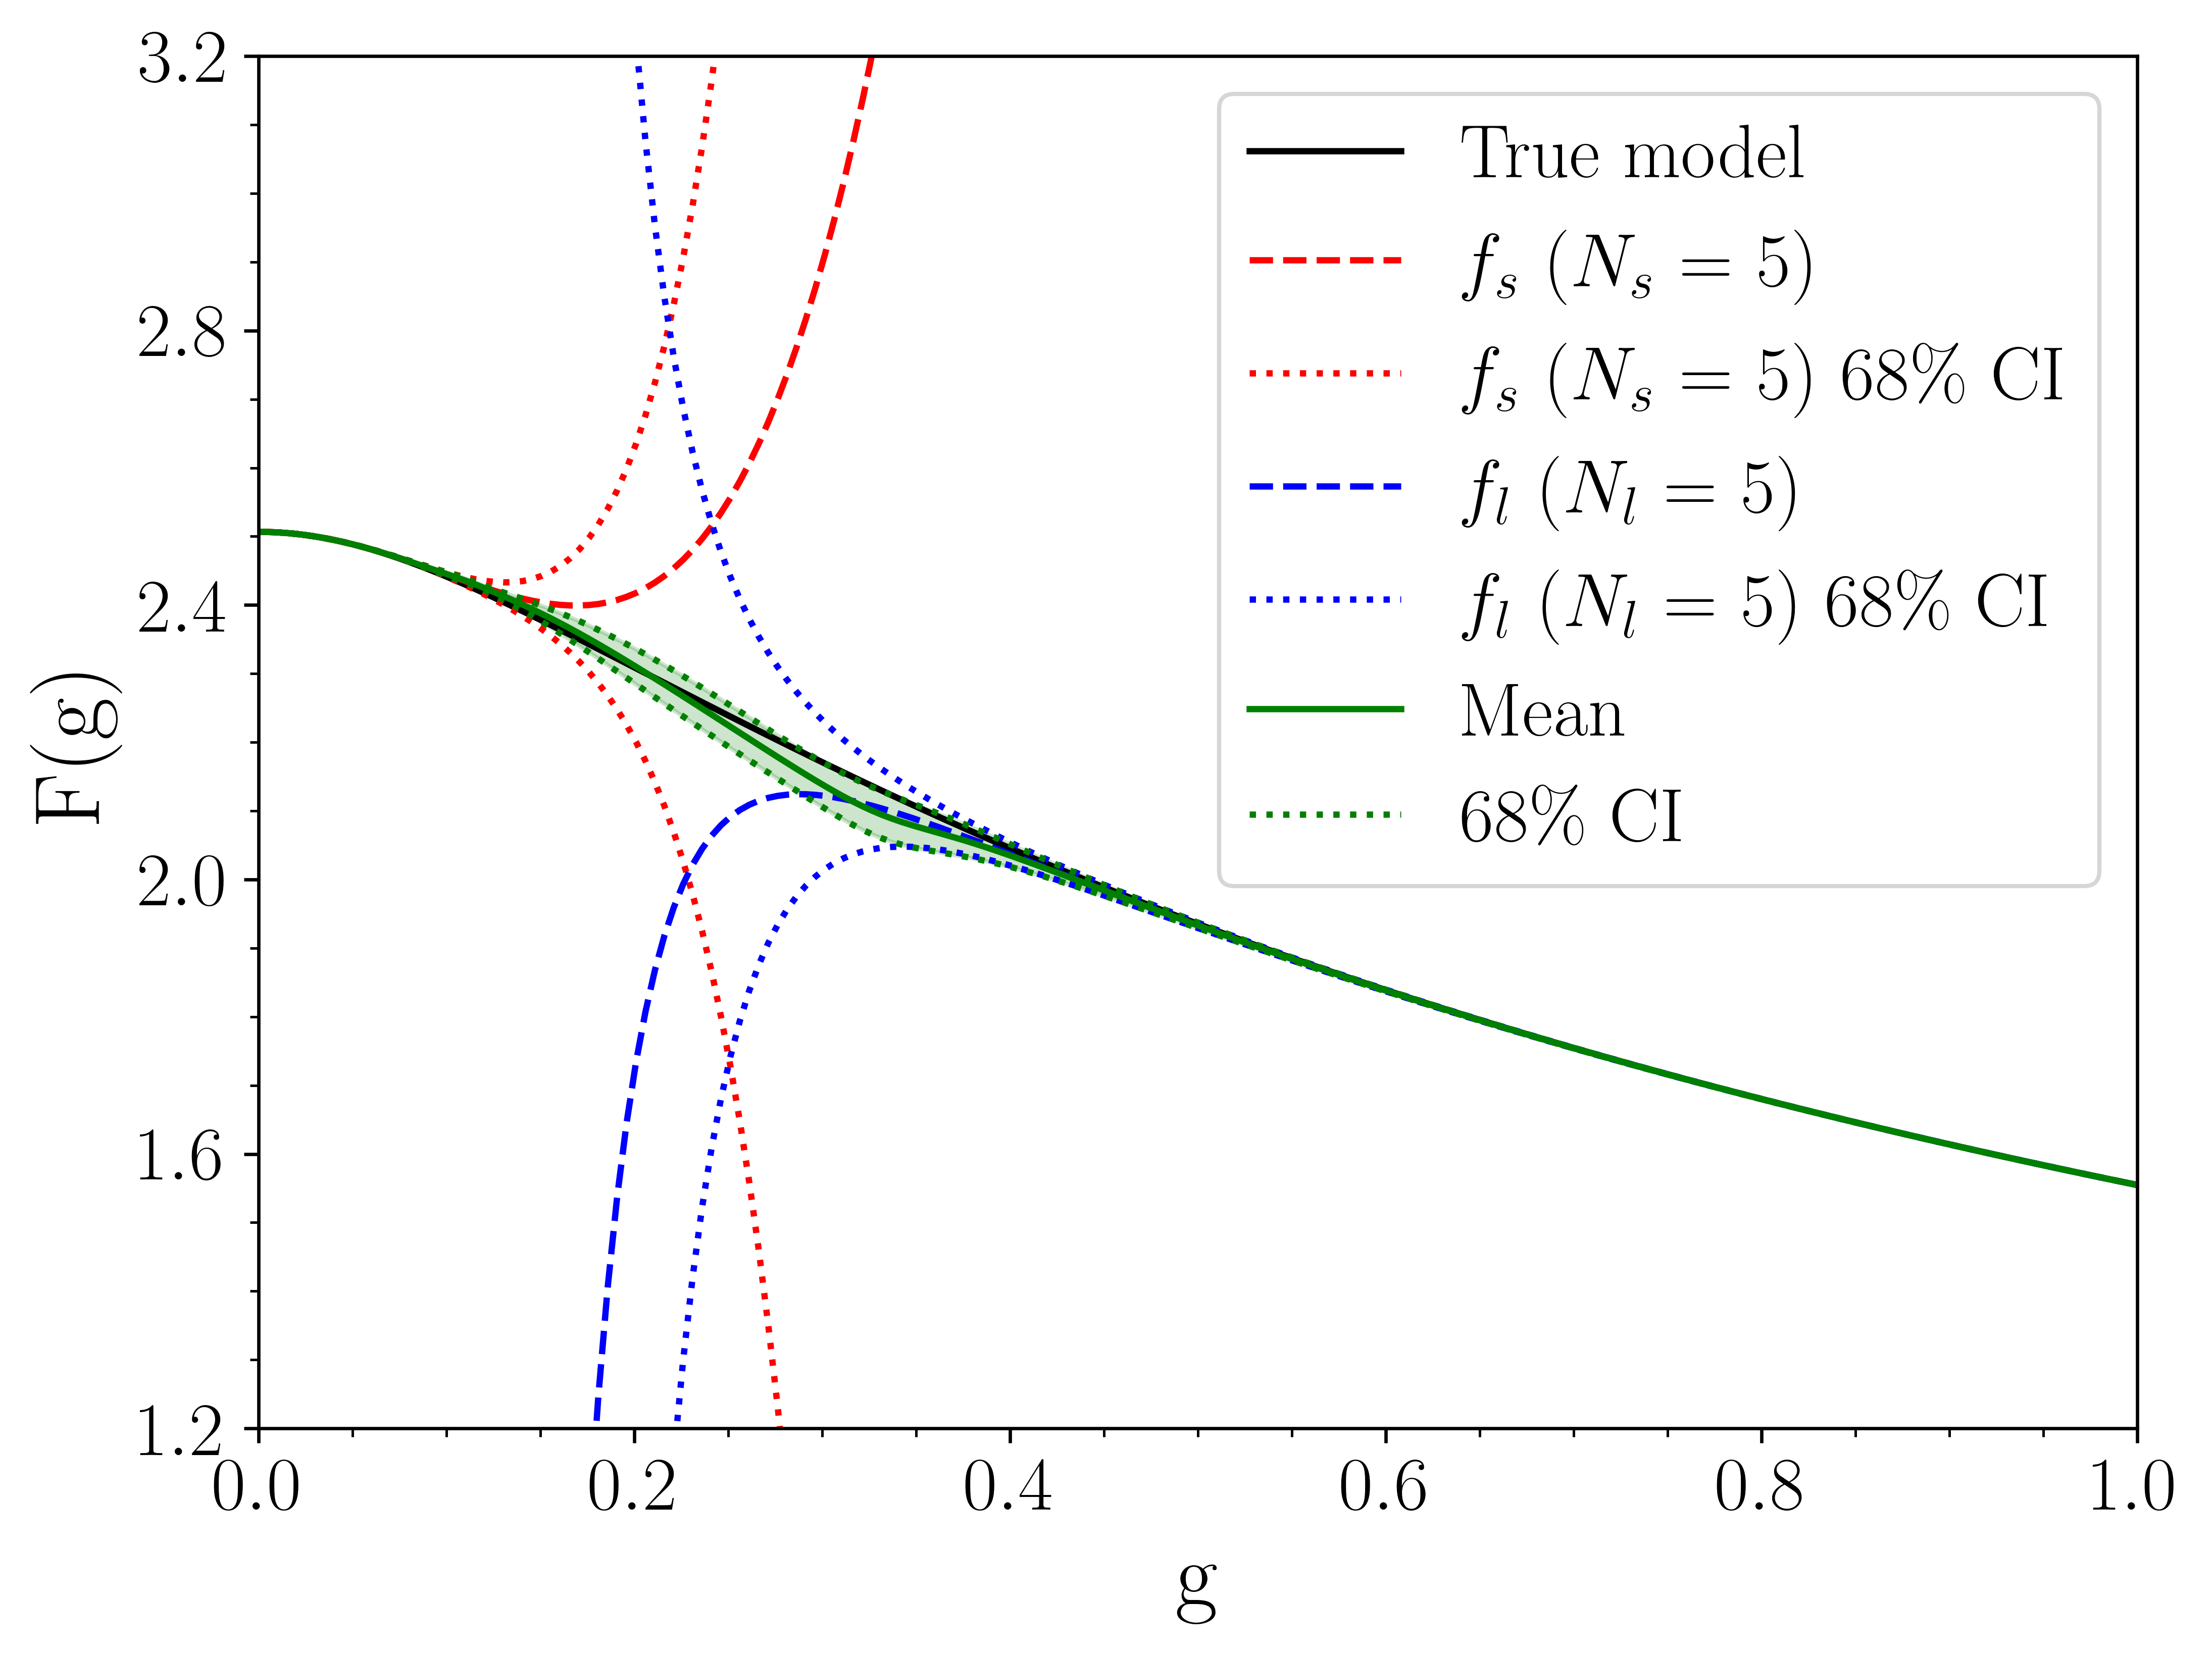

In [13]:
#new object for N_s = N_l = 5 and same steps as before
ns = 5
nl = 5
obj3 = GP(g, ns, nl, ci=68, kernel="Matern")
obj_tr3 = obj3.training()
mean3, sig3, cov3 = obj3.validate()
mixed_mean3, mixed_intervals3 = obj3.plot_mix(g, plot_fdagger=True, plot_true=True, GP_mean=mean3, GP_var=np.square(sig3))

These results also look pretty good! We can say that this method is by far the best for our toy model, and we cannot wait to apply this to real nuclear physics applications! Stay tuned for the next release, where __you__ will be able to input your own functions and test them in this sandbox!

Written by: Alexandra Semposki (07 June 2022)